In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv(r'C:\dataset-0510\train.csv')
testDf = pd.read_csv(r'C:\dataset-0510\test.csv')

In [2]:
df['city'].value_counts()

7     19664
13    10756
21     7964
12     7264
14     4704
10     4676
5      1224
9      1125
17      984
6       826
3       813
Name: city, dtype: int64

In [3]:
df['building_use'].value_counts()

2     51312
1      3069
5      2575
8      1014
6       752
10      722
0       369
3       119
7        37
4        31
Name: building_use, dtype: int64

In [4]:
df['building_type'].value_counts()

4    15902
0    15691
1    15049
3    10536
2     2822
Name: building_type, dtype: int64

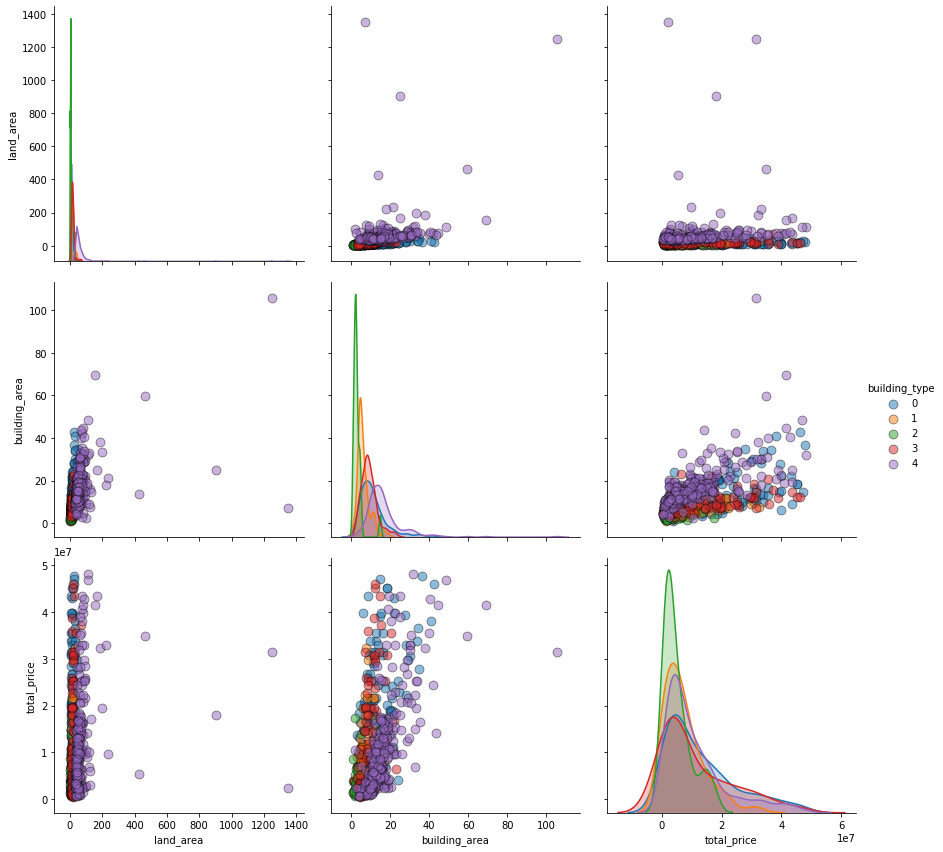

In [5]:
#總價與建坪有正相關，與地坪則無明顯相關。
#建議採用 building_area
plotDf=df
plotDf=df[df['total_price']<=50000000]
plotDf=plotDf[plotDf['building_use']==10]
sns.pairplot(plotDf, 
             vars = ['land_area','building_area','total_price'], diag_kind = 'kde', hue='building_type',
             plot_kws = {'alpha': 0.5, 's': 80, 'edgecolor': 'k'},
             size = 4);

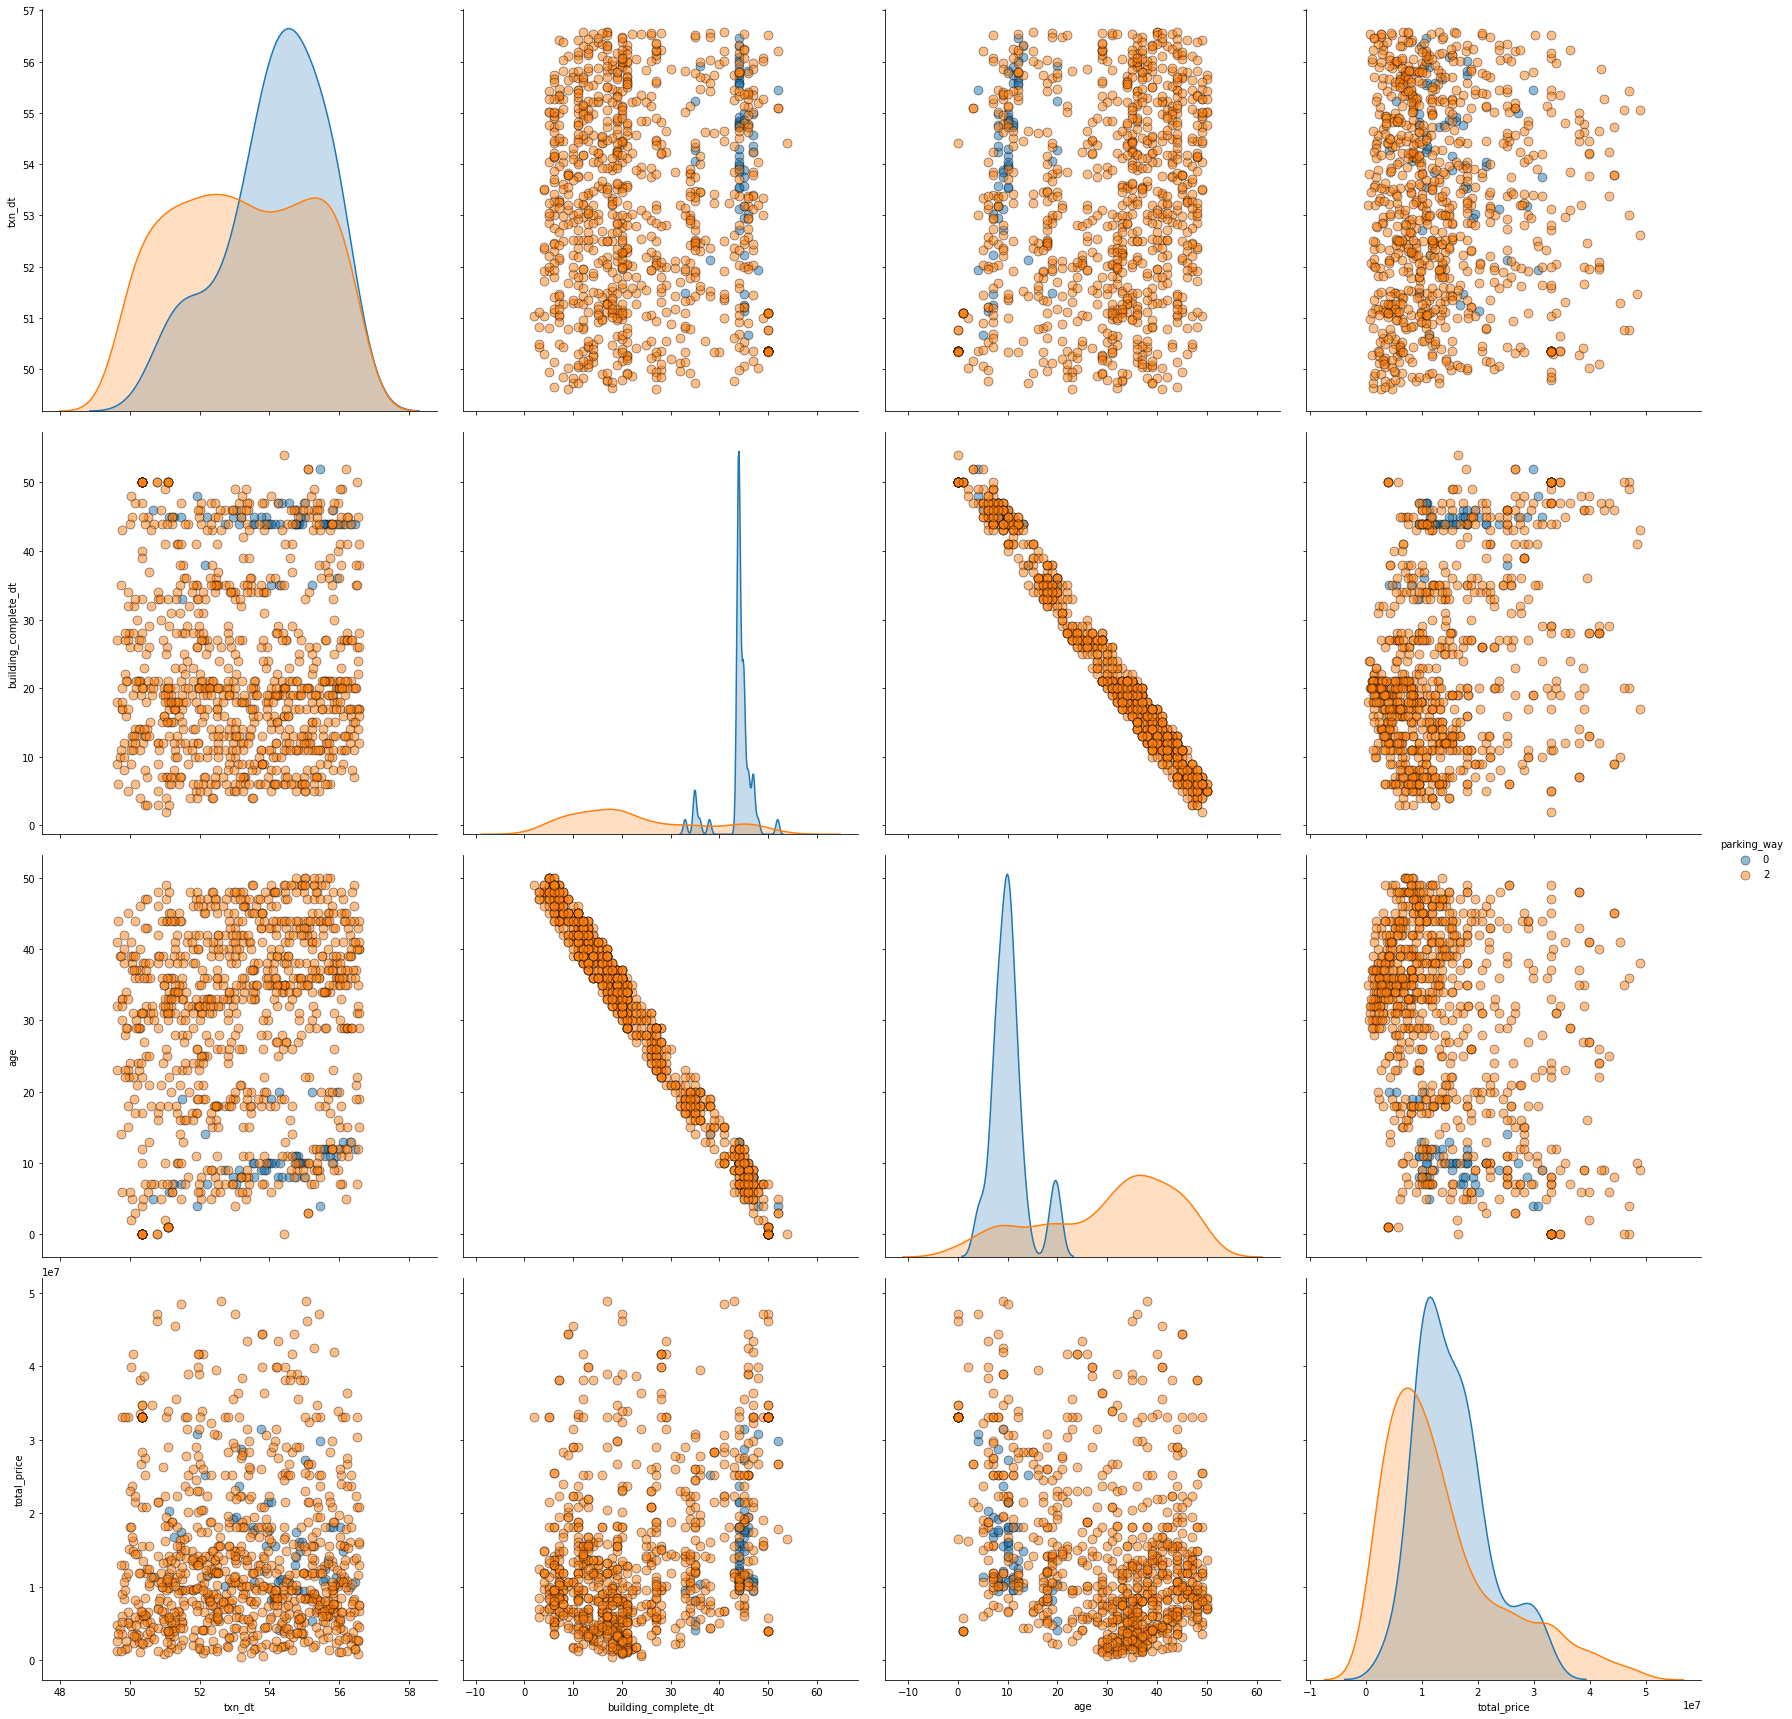

In [6]:
#有特別規劃出車位的透天資料筆數極少，但有可能是未來的趨勢。(以city=7為例，只有71筆；無車位相對有1124筆)
plotDf=df[df['total_price']<=50000000]
plotDf=plotDf[plotDf['city']==7]
plotDf['age']=round((plotDf['txn_dt']-plotDf['building_complete_dt'])/365)
plotDf['building_complete_dt']=round(plotDf['building_complete_dt']/365)
plotDf['txn_dt']=plotDf['txn_dt']/365
plotDf=plotDf[plotDf['building_type']==4]
plotDf=plotDf[plotDf['building_use']==2]
sns.pairplot(plotDf, 
             vars = ['txn_dt','building_complete_dt','age','total_price'], diag_kind = 'kde', hue='parking_way',
             plot_kws = {'alpha': 0.5, 's': 80, 'edgecolor': 'k'},
             size = 6);

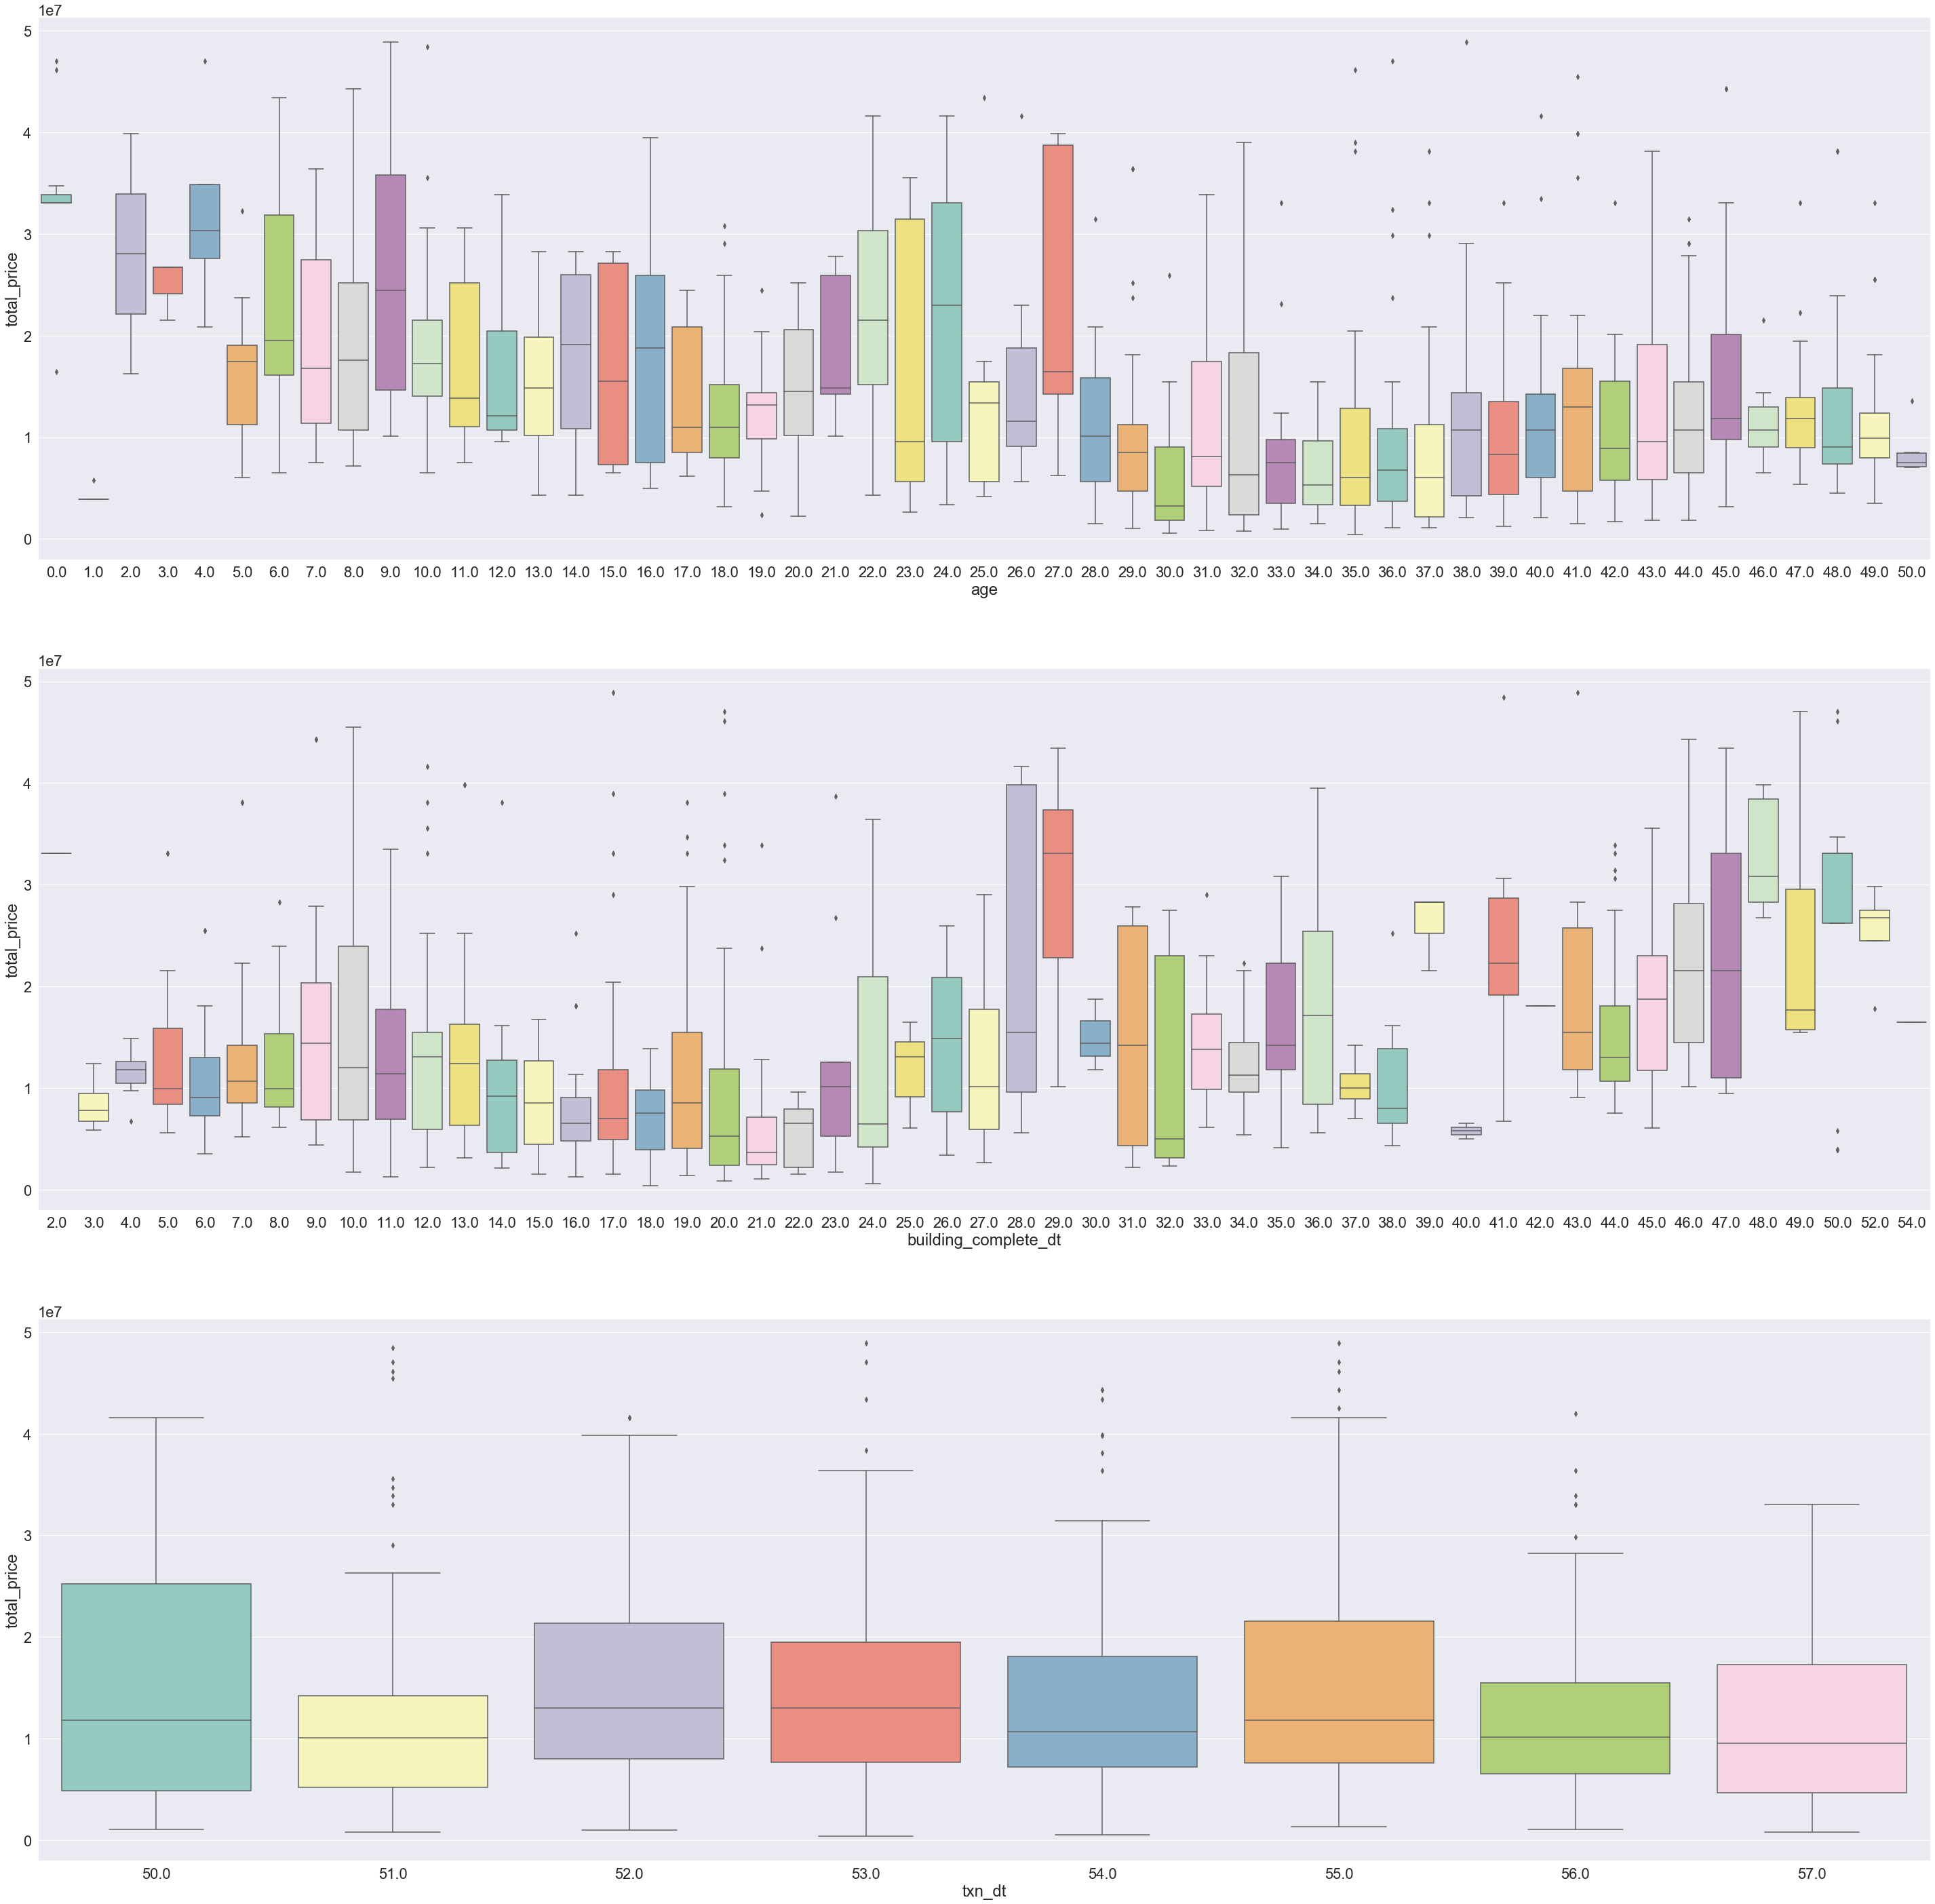

In [7]:
#房價大致上與屋齡成反比
#建物完成的日期越晚，則房價越高
#建議採用 age,building_complete_dt
plotDf['txn_dt']=round(plotDf['txn_dt'])
sns.set(font_scale=2)
f = plt.figure(figsize=(50,50)) 
f.add_subplot(3, 1, 1) 
sns.boxplot(x="age", y="total_price",data=plotDf, palette="Set3")
f.add_subplot(3, 1, 2) 
sns.boxplot(x="building_complete_dt", y="total_price",data=plotDf, palette="Set3")
f.add_subplot(3, 1, 3) 
sns.boxplot(x="txn_dt", y="total_price",data=plotDf, palette="Set3")

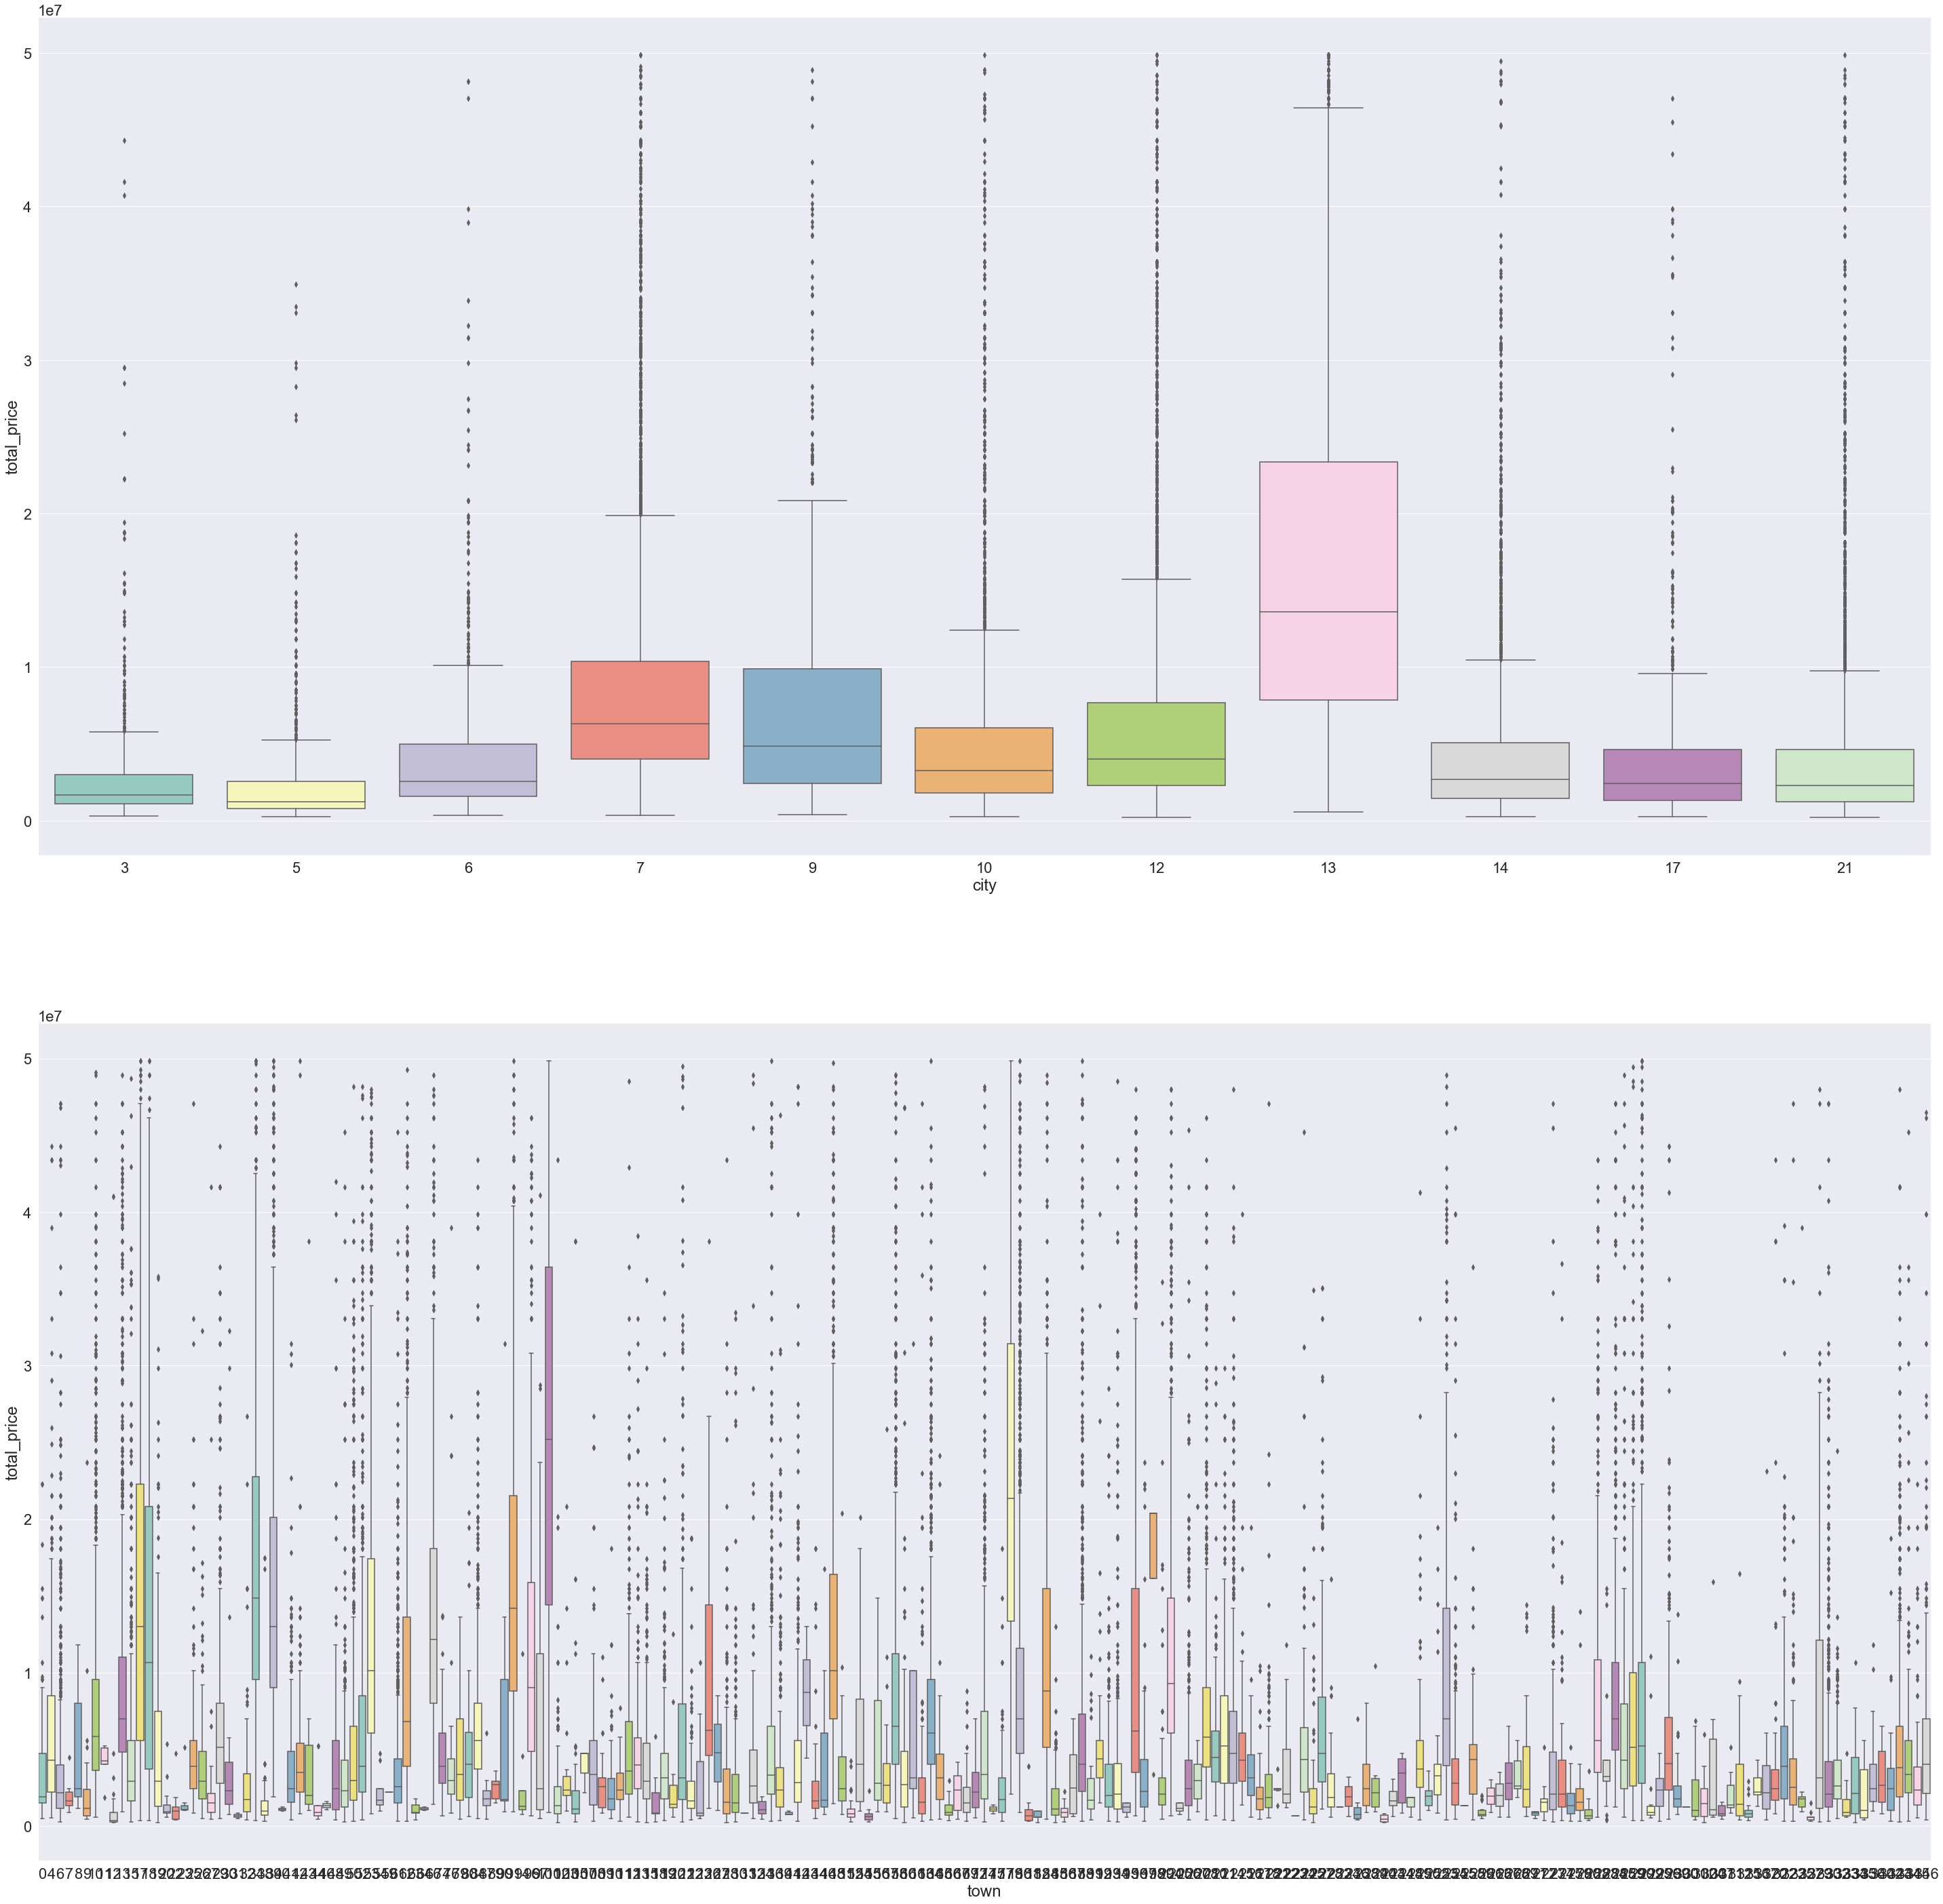

In [8]:
#各城鄉明顯有自己的價格區間
#建議採用 city 縣市 , town 鄉鎮市區  
plotDf=df[df['total_price']<=50000000]
sns.set(font_scale=2)
f = plt.figure(figsize=(50,50)) 
f.add_subplot(2, 1, 1) 
sns.boxplot(x="city", y="total_price",data=plotDf, palette="Set3")
f.add_subplot(2, 1, 2) 
sns.boxplot(x="town", y="total_price",data=plotDf, palette="Set3")

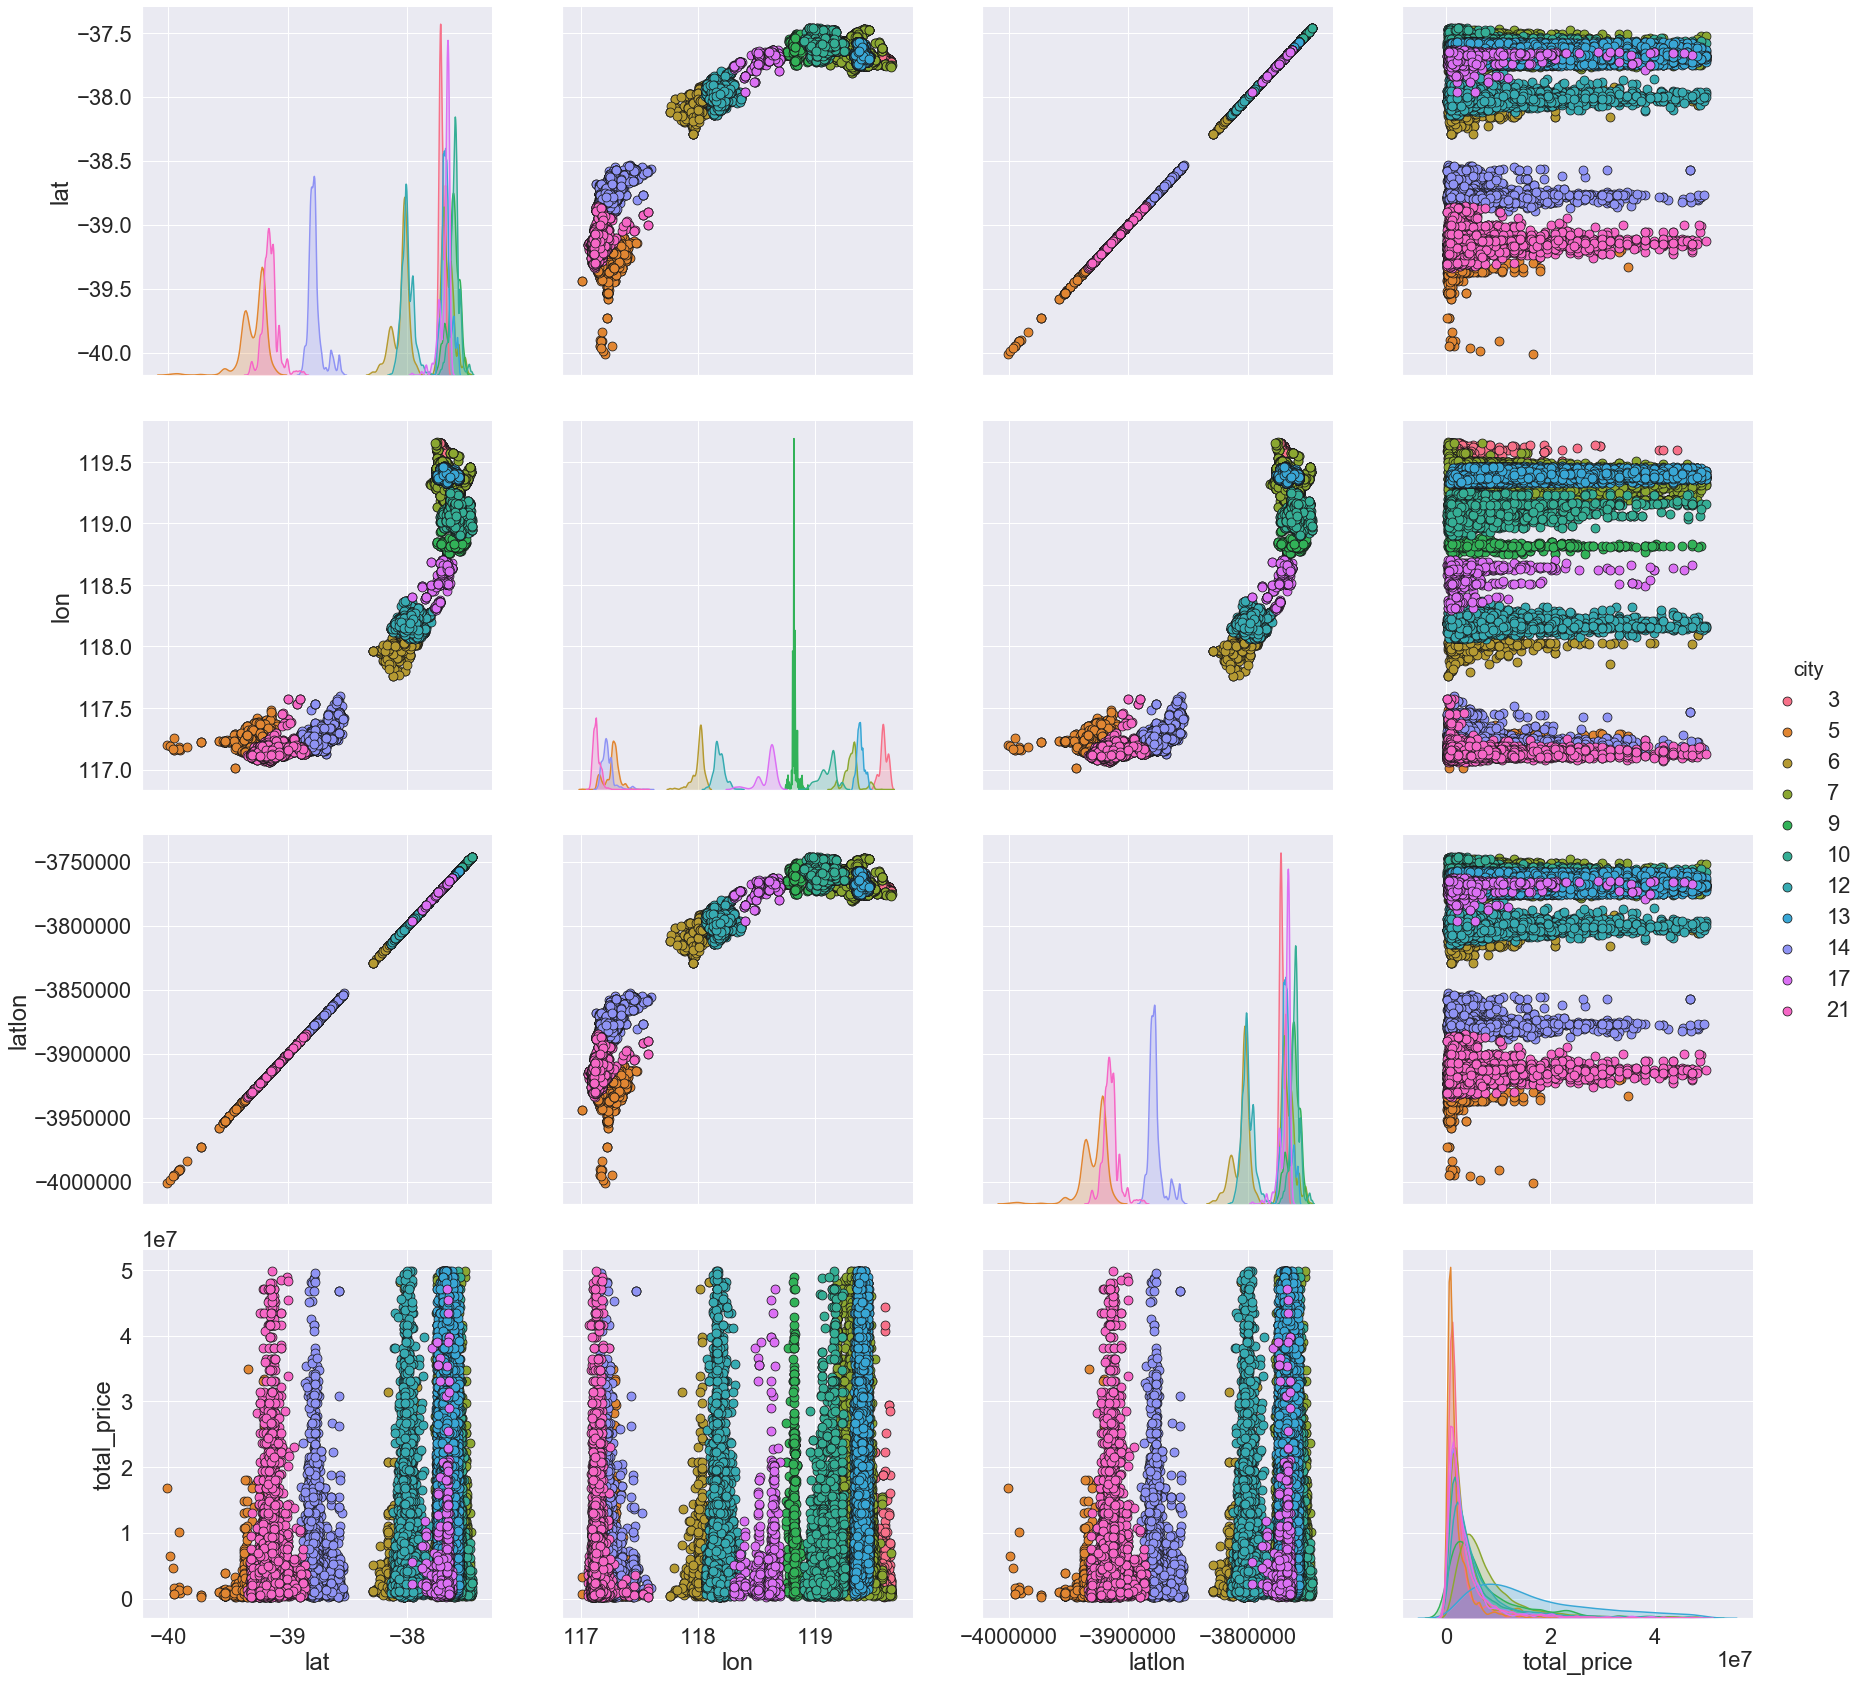

In [9]:
# 從經緯度可以看出每個city有自己的"蛋黃區"，但直接使用經緯度意義不大。(包含latlon)
# 對角線單個變量的分布
# lat : 建物緯度
# lon : 建物經度
plotDf=df[df['total_price']<=50000000]
plotDf['latlon']=plotDf['lat']*100000+plotDf['lon']
sns.set(font_scale=2)
## 使用 seaborn 繪製多變量圖
## Pairs Plots
sns.pairplot(plotDf,
             vars = ['lat','lon','latlon','total_price'], diag_kind = 'kde', hue='city',
             plot_kws = {'alpha': 1, 's': 80, 'edgecolor': 'k'},
             size = 6);

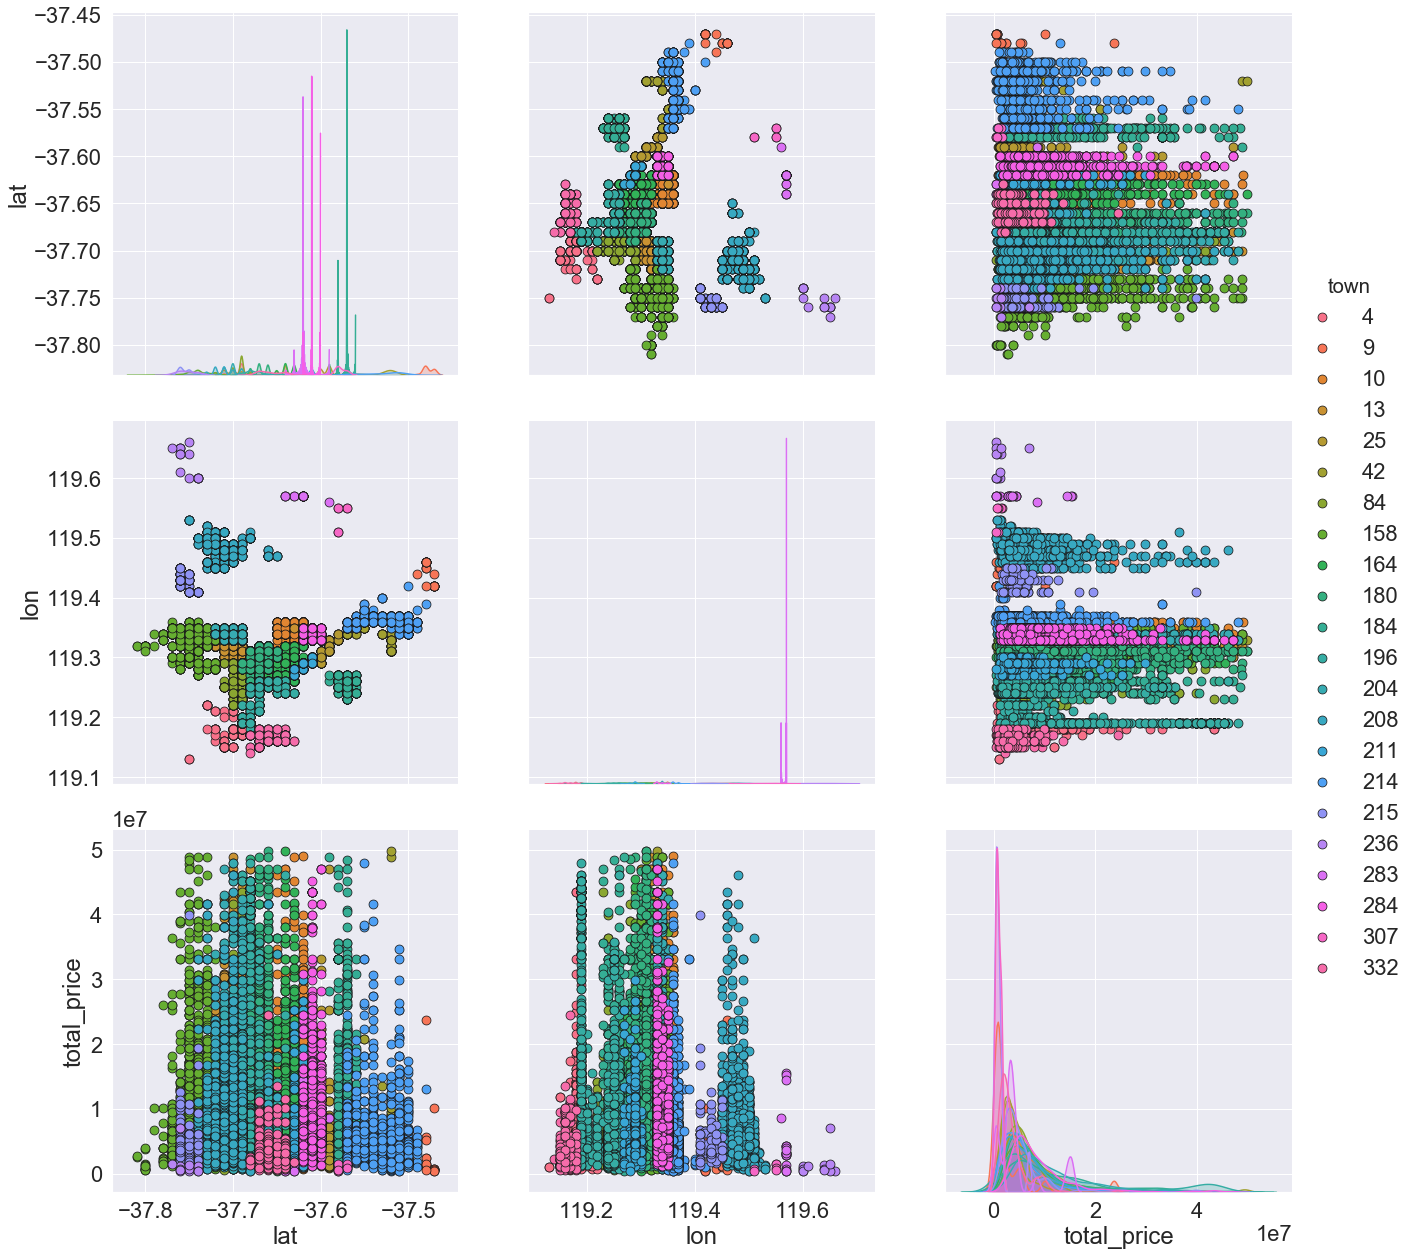

In [10]:
#取最大的City 7出來進一步分析，又能發現每個Town有自己的蛋黃區 (但不像City那麼顯著)
plotDf=df[df['total_price']<=50000000]
plotDf=plotDf[plotDf['city']==7]
sns.set(font_scale=2)
sns.pairplot(plotDf, 
             vars = ['lat','lon','total_price'], diag_kind = 'kde', hue='town',
             plot_kws = {'alpha': 1, 's': 80, 'edgecolor': 'k'},
             size = 6);

In [11]:
#找出city 7中最大的town
plotDf['town'].value_counts()

180    2503
13     2246
10     2032
158    1731
164    1624
208    1413
204    1261
284    1117
84     1091
196     997
214     785
4       638
184     632
211     360
25      358
332     219
42      145
215      95
9        24
283      21
236      14
307       6
Name: town, dtype: int64

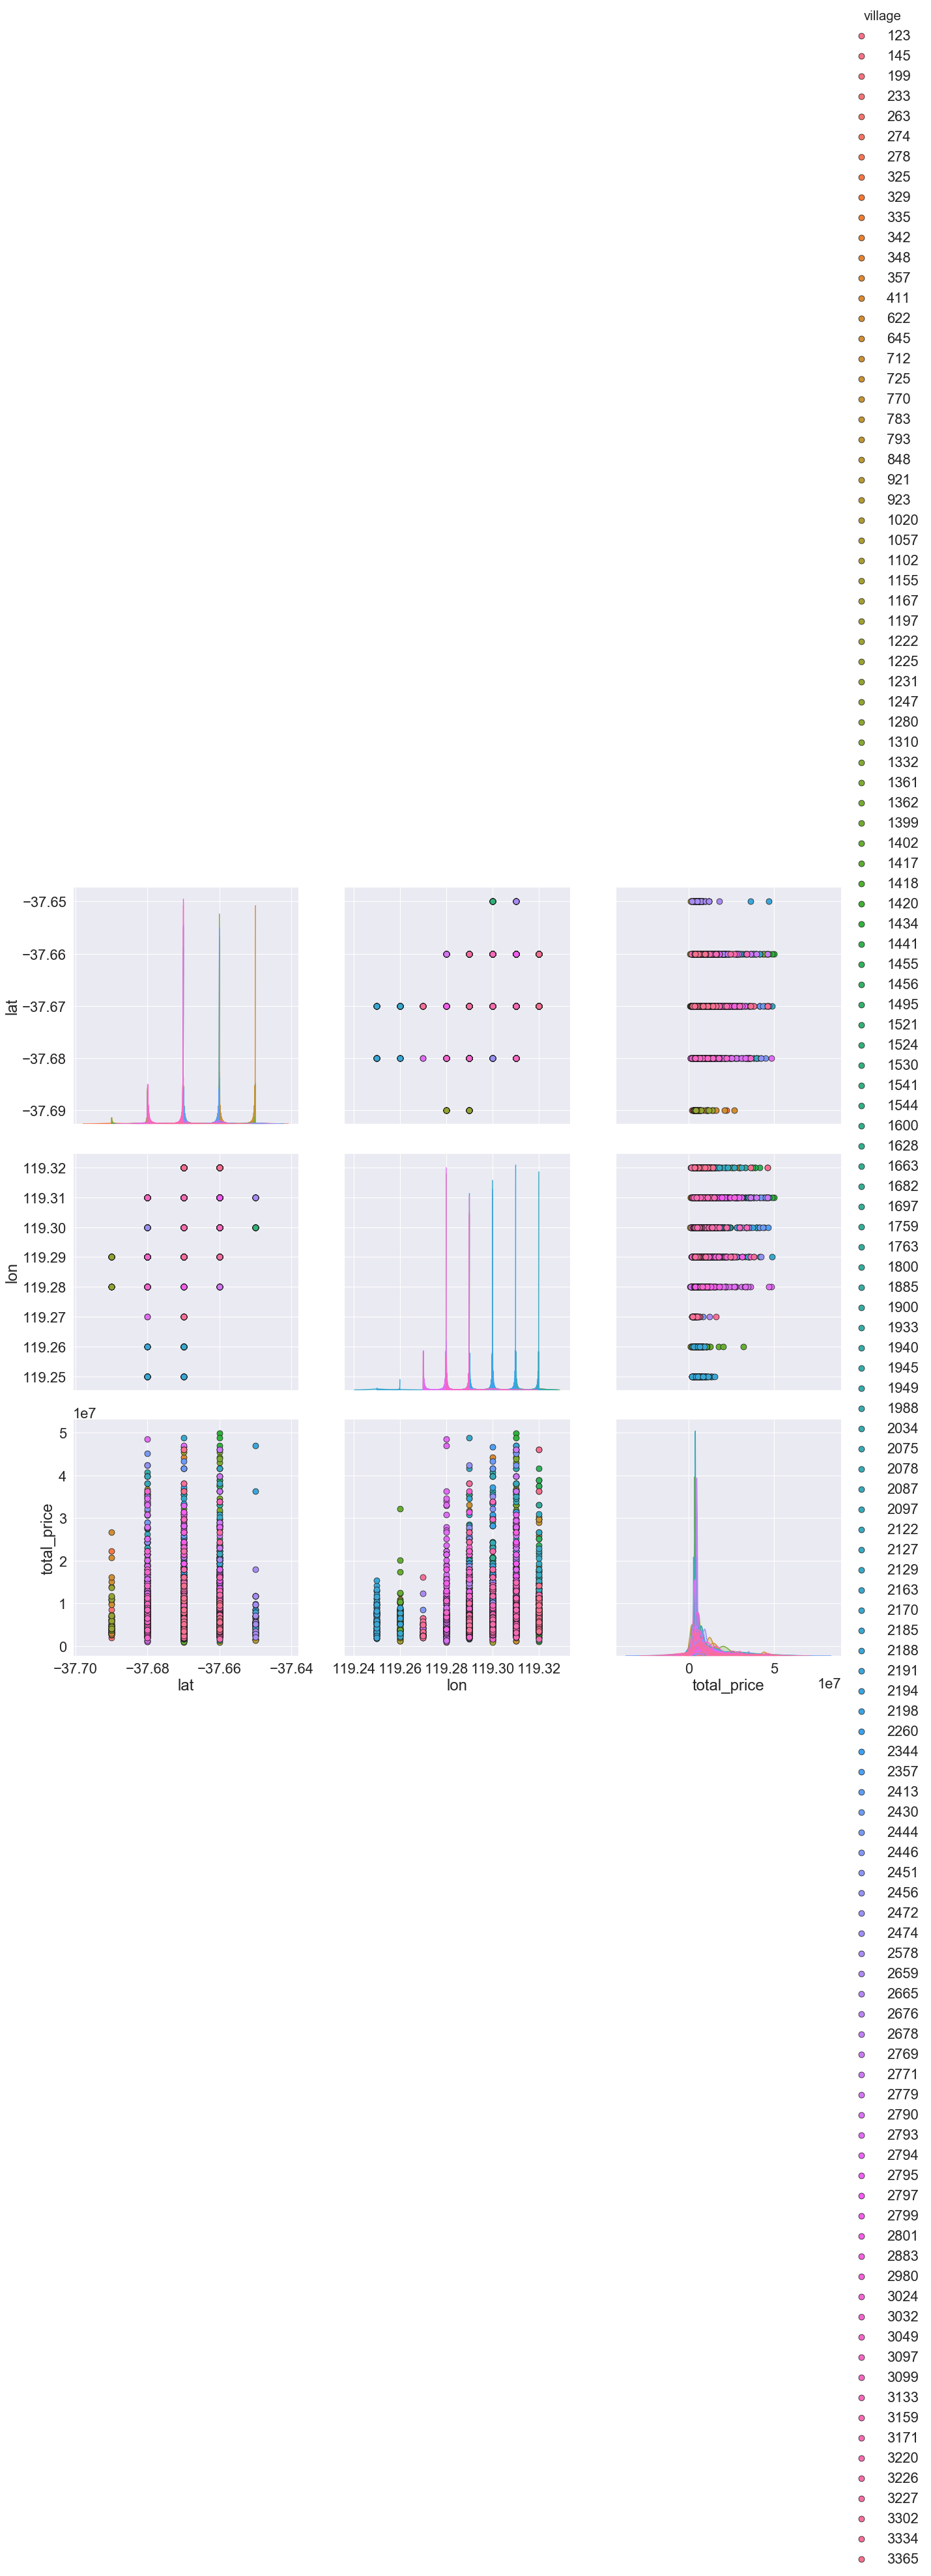

In [12]:
#針對City 7中最大的Town180進行分析，則已經看不出有所謂的蛋黃區
#也說明了資料的經緯度其實就是Village的中心點
plotDf=df[df['total_price']<=50000000]
plotDf=plotDf[plotDf['city']==7]
plotDf=plotDf[plotDf['town']==180]
sns.set(font_scale=2)
sns.pairplot(plotDf, 
             vars = ['lat','lon','total_price'], diag_kind = 'kde', hue='village',
             plot_kws = {'alpha': 1, 's': 80, 'edgecolor': 'k'},
             size = 6);

In [13]:
#開始經緯度特徵工程
#計畫如下:
#1.找出每個City的蛋黃中心點,取出City中前75%高價 Total Price的資料，並計算其經緯度的平均值
#2.計算其他點與蛋黃中心的距離，並以此產生新的特徵
def countCityDis(df,inputCity):
    highAvg=df.ix[df.city==inputCity,'total_price'].quantile(0.8) #80%分位数
    subDf=df[df['city']==inputCity]
    subDf=subDf[subDf['total_price']>=highAvg]
    cityLat=subDf['lat'].mean()
    cityLon=subDf['lon'].mean()
    df.ix[df.city==inputCity,'cityLat']=cityLat
    df.ix[df.city==inputCity,'cityLon']=cityLon
    print(str(inputCity)+" "+str(cityLat)+" "+str(cityLon))
    #得出距離蛋黃區的歐氏距離
    df['cityDis']=np.sqrt((df['lat']-df['cityLat'])**2+(df['lon']-df['cityLon'])**2)
    return df
#Town比照辦理
def countCTDis(df,inputCT):
    highAvg=df.ix[df.CT==inputCT,'total_price'].quantile(0.8) #80%分位数
    subDf=df[df['CT']==inputCT]
    subDf=subDf[subDf['total_price']>=highAvg]
    CTLat=subDf['lat'].mean()
    CTLon=subDf['lon'].mean()
    df.ix[df.CT==inputCT,'CTLat']=CTLat
    df.ix[df.CT==inputCT,'CTLon']=CTLon
    #得出距離蛋黃區的歐氏距離
    df['CTDis']=np.sqrt((df['lat']-df['CTLat'])**2+(df['lon']-df['CTLon'])**2)
    #df['CTAvgType0_mean']=df.ix[(df.CT==inputCT) & (df.building_type==0),'avg'].describe()['mean']
    return df

df['avg']=df['total_price']/df['building_area']

#利用CITY與TOWN組出新特徵CT
df['CT']=df['city']*1000+df['town']

#計算每筆資料距離城市蛋黃區距離
cityList=df['city'].unique().tolist()
for city in cityList:
    df=countCityDis(df,city)

#計算每筆資料距離鄉鎮蛋黃區距離
CTList=df['CT'].unique().tolist()
for CT in CTList:
    df=countCTDis(df,CT) 
#產生之新特徵為 df['cityDis'] (與City蛋黃區距離) df['CTDis'] (與Town蛋黃區距離)

21 -39.141927181418794 117.1307658505968
7 -37.66880241024381 119.31226713532583
12 -38.00371176070687 118.1758395649223
17 -37.68126903553296 118.60761421319803
10 -37.59170010559674 119.13065469904964
13 -37.67609453877912 119.39548875631134
14 -38.77950053134967 117.21947927736448
3 -37.70914110429446 119.58061349693244
6 -38.05036144578316 118.0124698795181
5 -39.265877551020395 117.26738775510195
9 -37.62302631578948 118.8196491228071


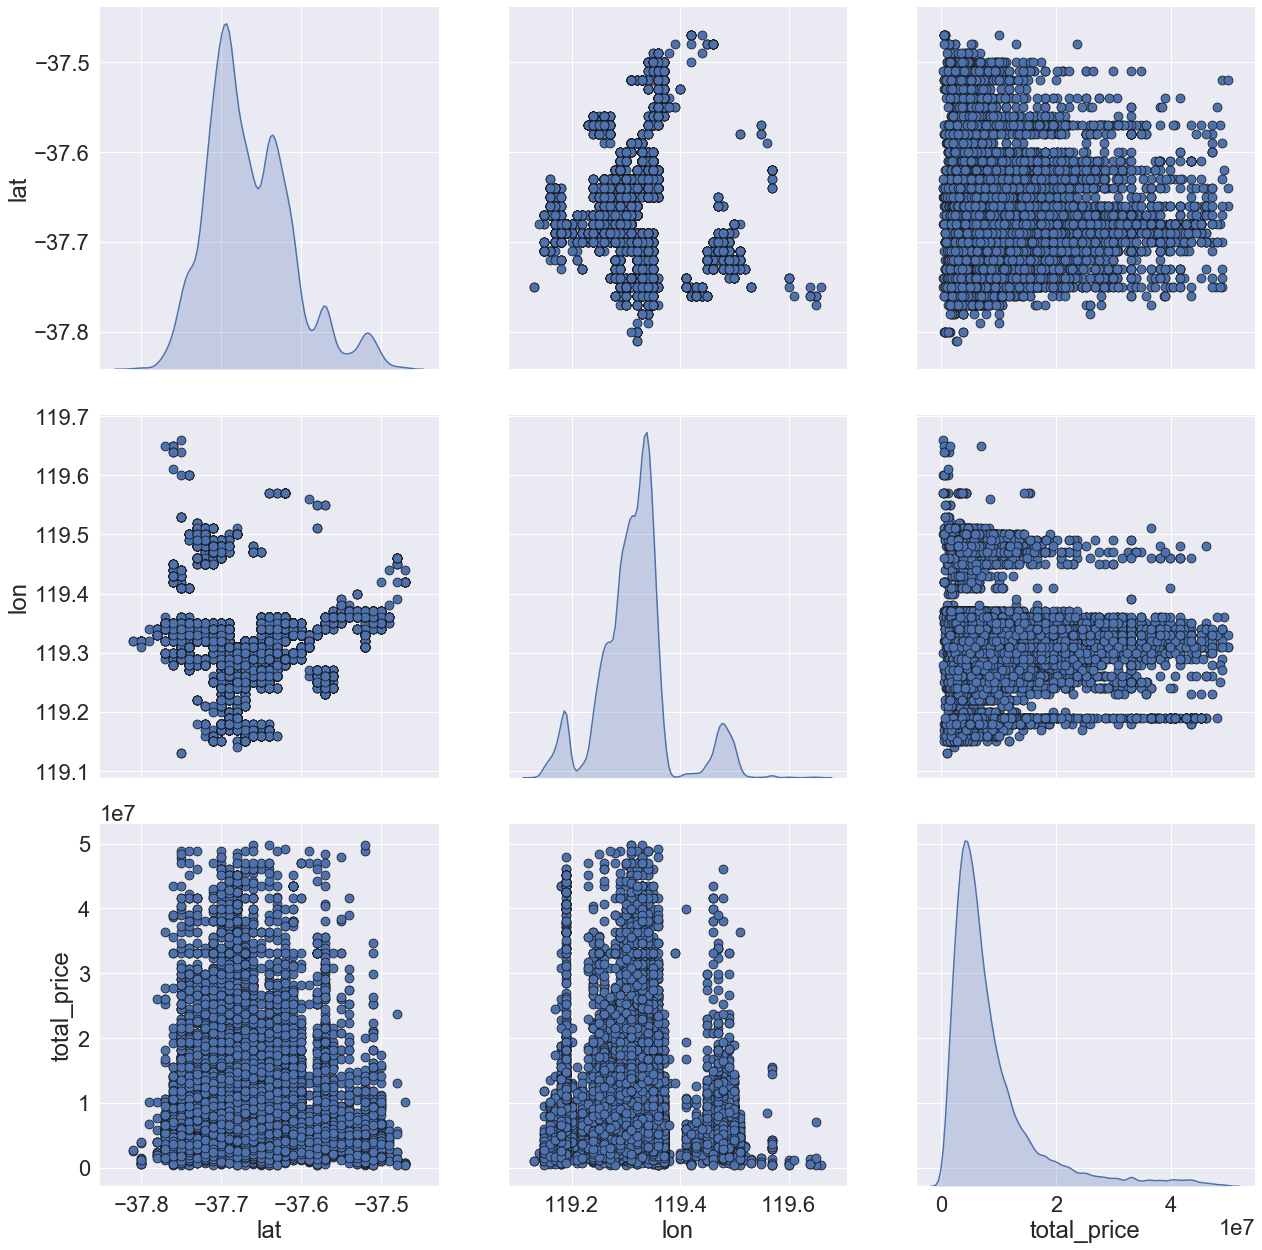

In [14]:
#抽驗city=7,市中心統計為-37.668,119.312，看起來OK。
plotDf=df[df['total_price']<=50000000]
plotDf=plotDf[plotDf['city']==7]
sns.set(font_scale=2)
sns.pairplot(plotDf, 
             vars = ['lat','lon','total_price'], diag_kind = 'kde',
             plot_kws = {'alpha': 1, 's': 80, 'edgecolor': 'k'},
             size = 6);

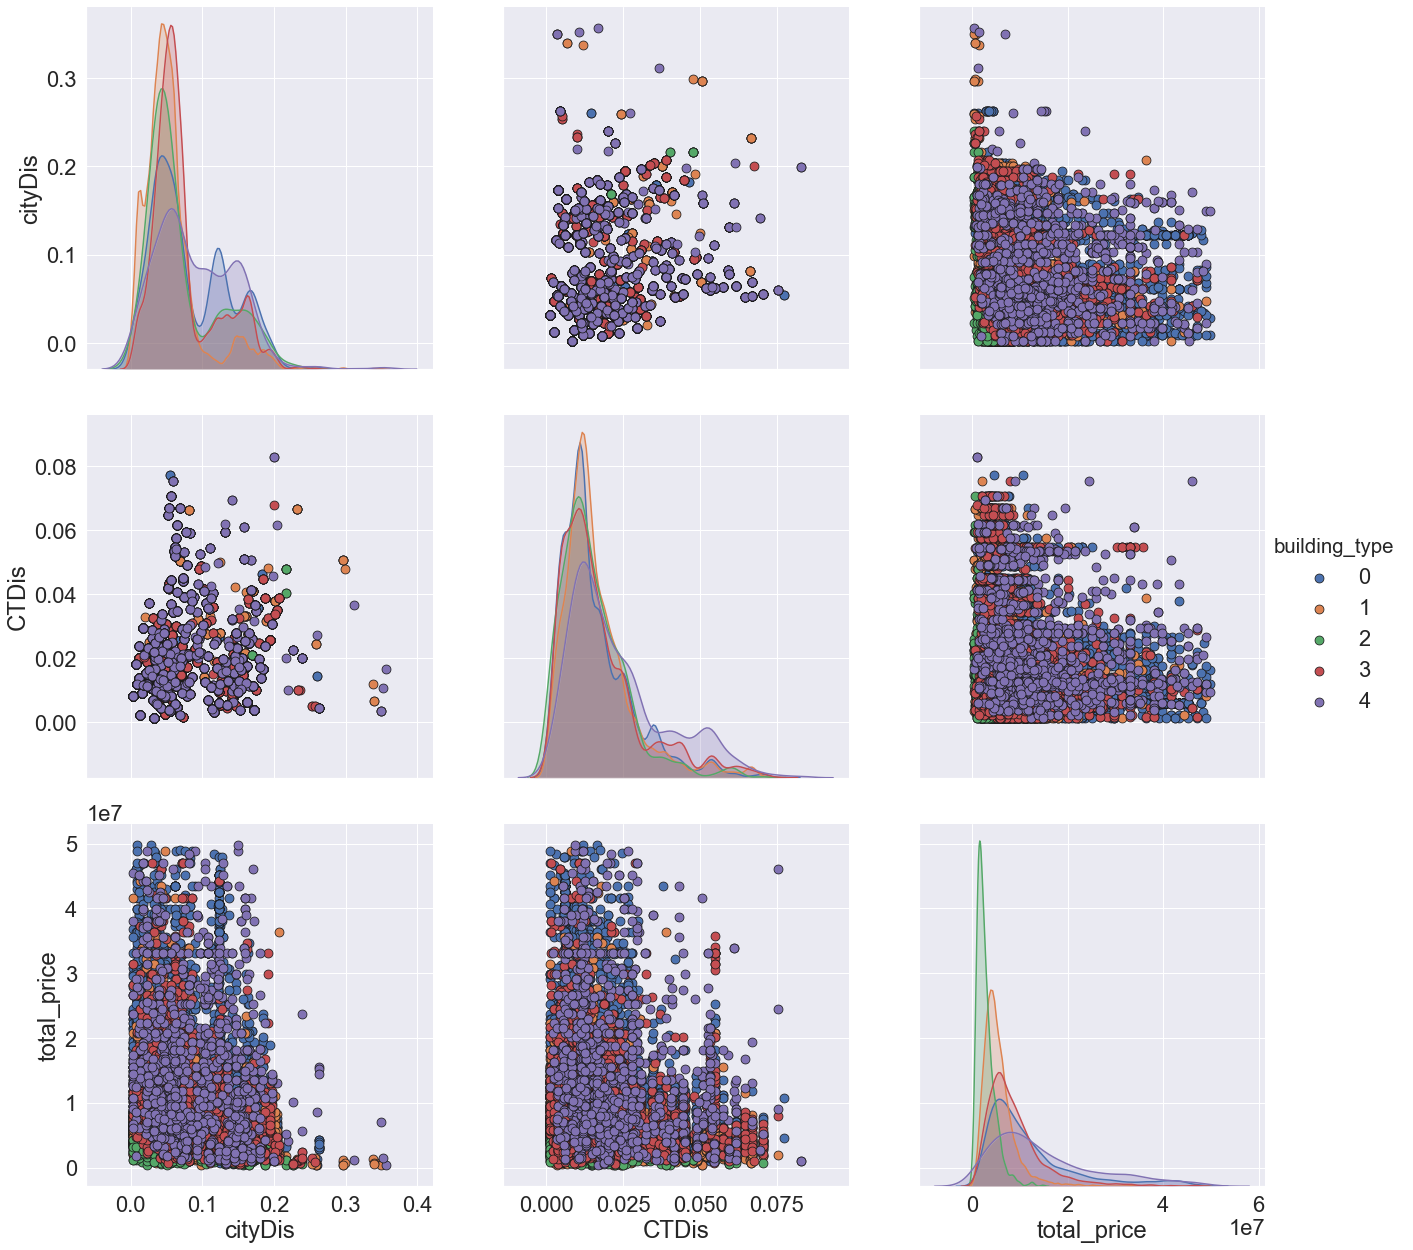

In [20]:
#查看新特徵與總價之間的相關性，出現負相關(離蛋黃區越遠總價越低)
#故建議加上特徵 'cityDis' (與City蛋黃區距離) 'CTDis' (與Town蛋黃區距離)
plotDf=plotDf[plotDf['city']==7]
sns.set(font_scale=2)
sns.pairplot(plotDf, 
             vars = ['cityDis','CTDis','total_price'], diag_kind = 'kde', hue='building_type',
             plot_kws = {'alpha': 1, 's': 80, 'edgecolor': 'k'},
             size = 6);

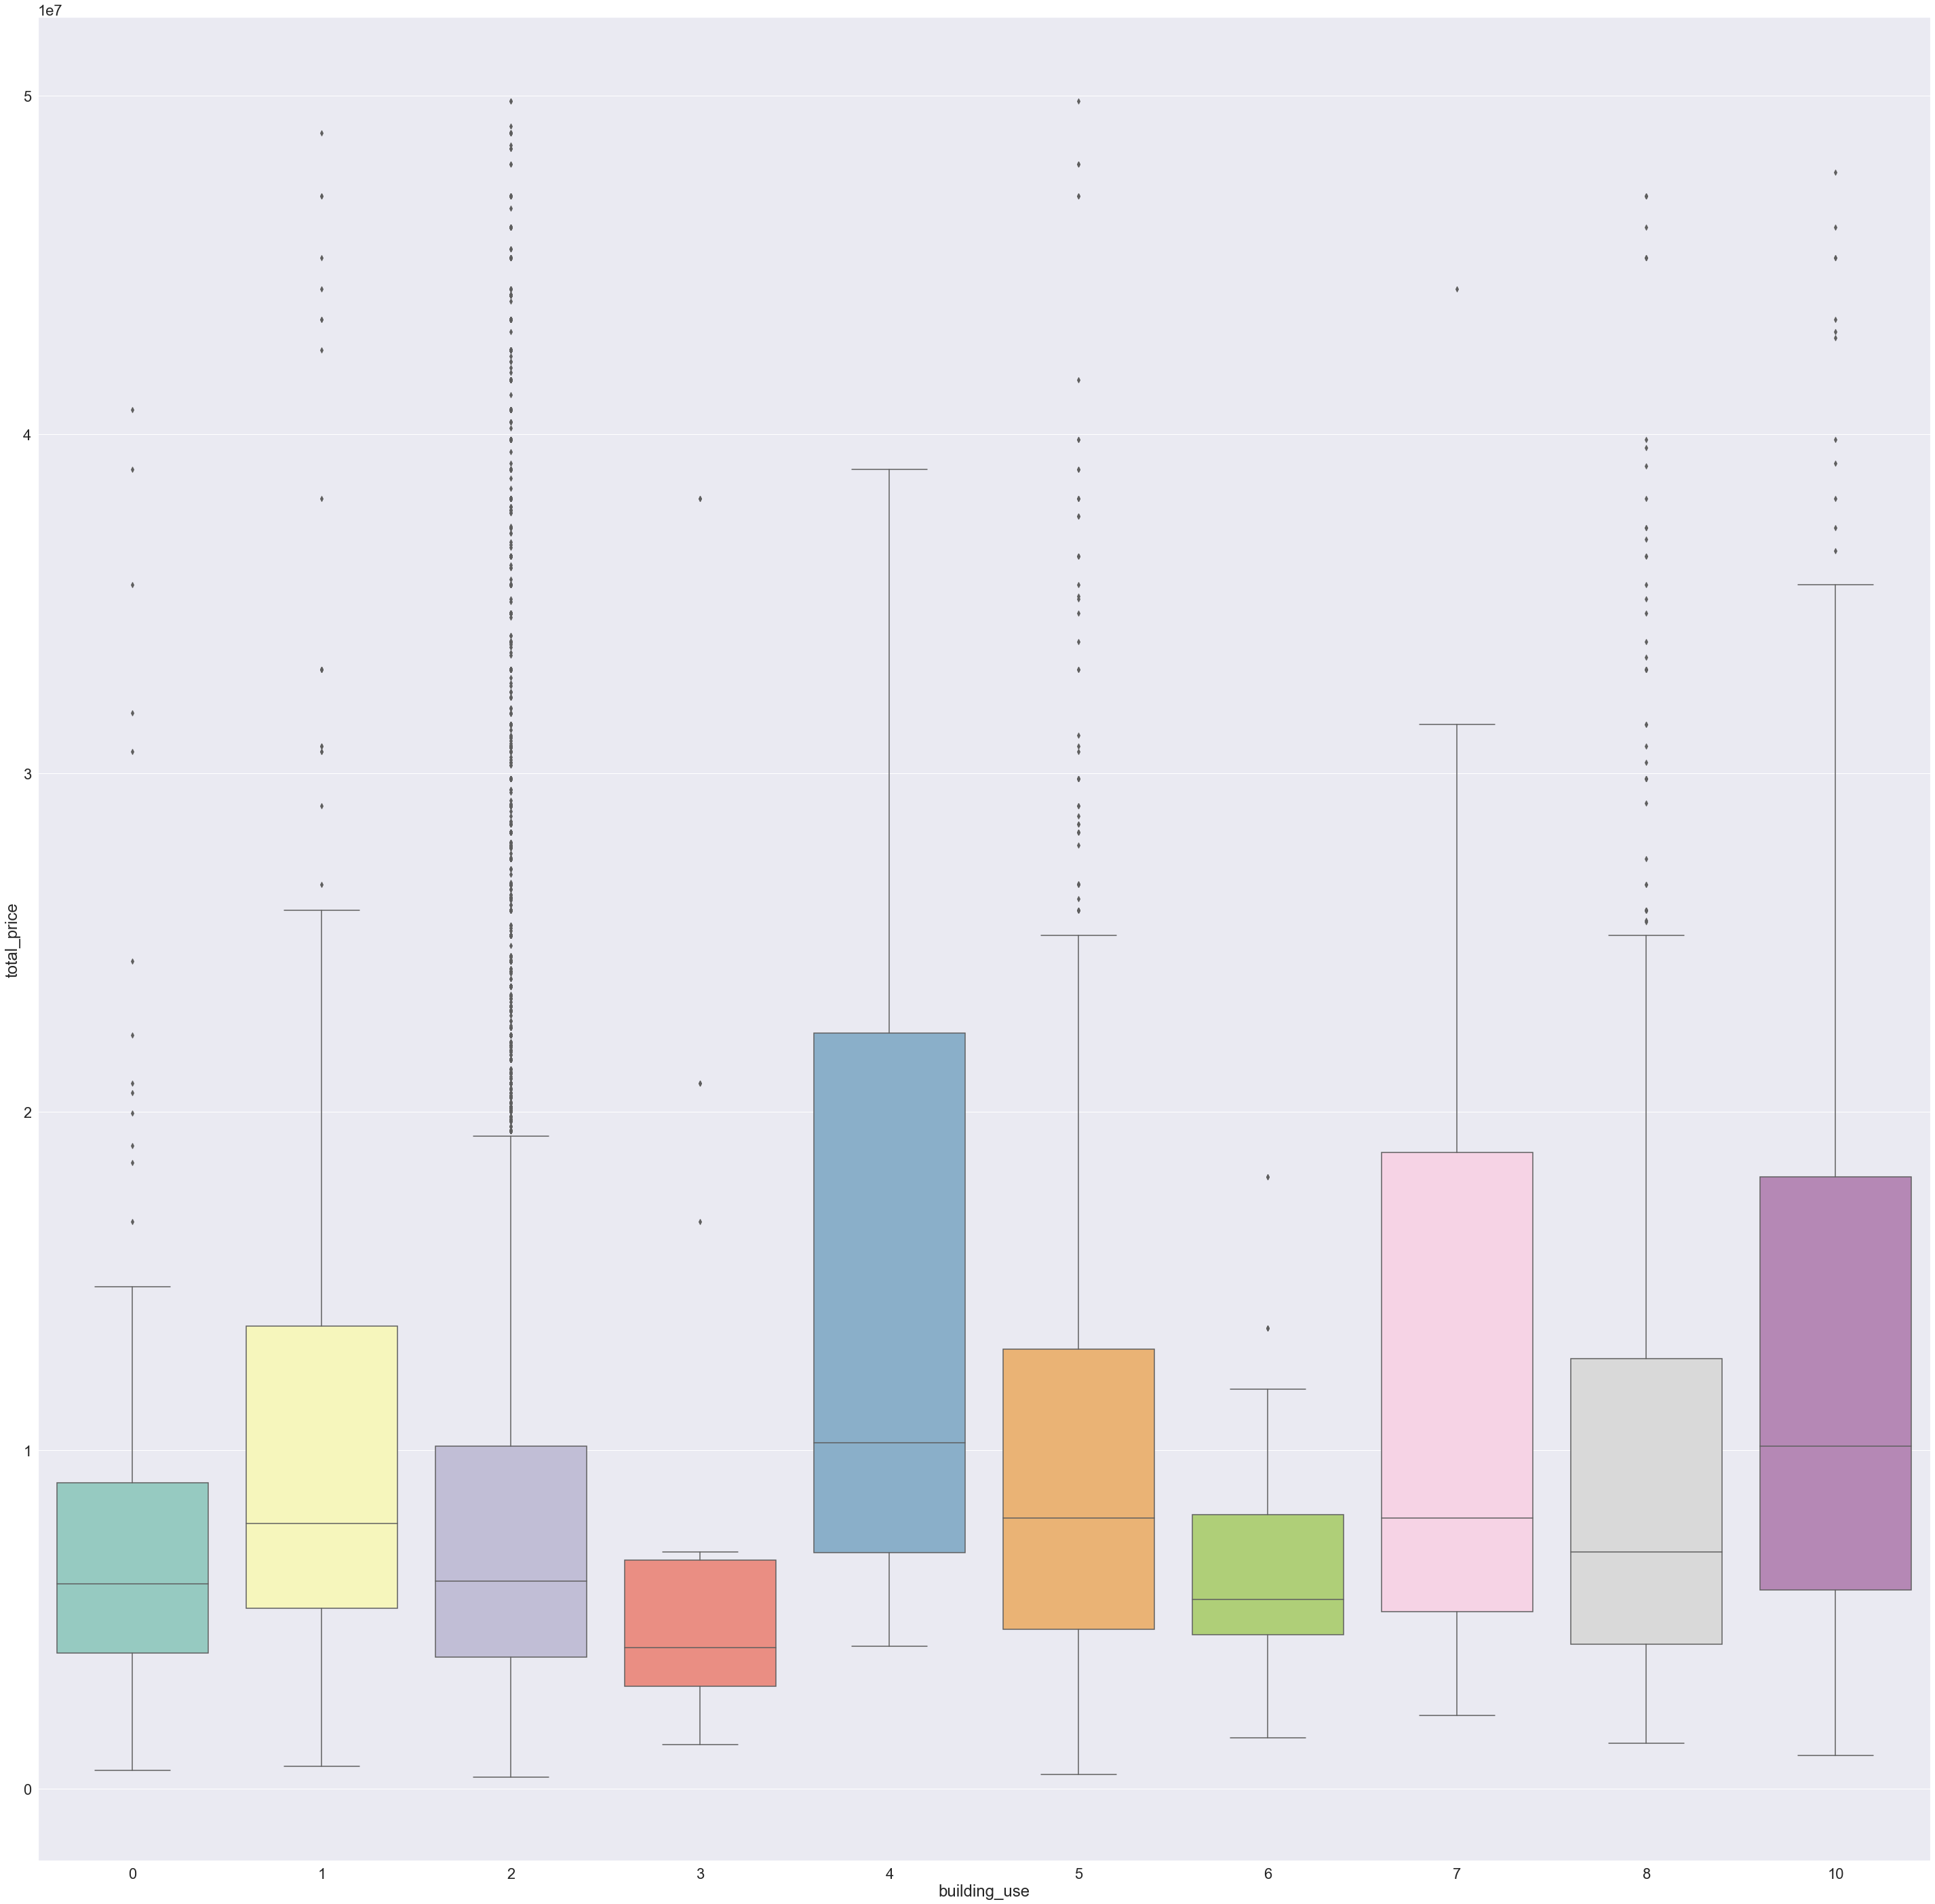

In [16]:
#查驗哪種use為商用
#後續證明4應為商用
plotDf['txn_dt']=round(plotDf['txn_dt'])
sns.set(font_scale=2)
f = plt.figure(figsize=(50,50)) 
sns.boxplot(x="building_use", y="total_price",data=plotDf, palette="Set3")

In [17]:
#查看building_use分布
buildDf=df[df['building_type']==4]
buildDf['building_use'].value_counts()

2     12471
1      2508
10      271
8       268
5       132
0       110
3        98
6        25
7        18
4         1
Name: building_use, dtype: int64

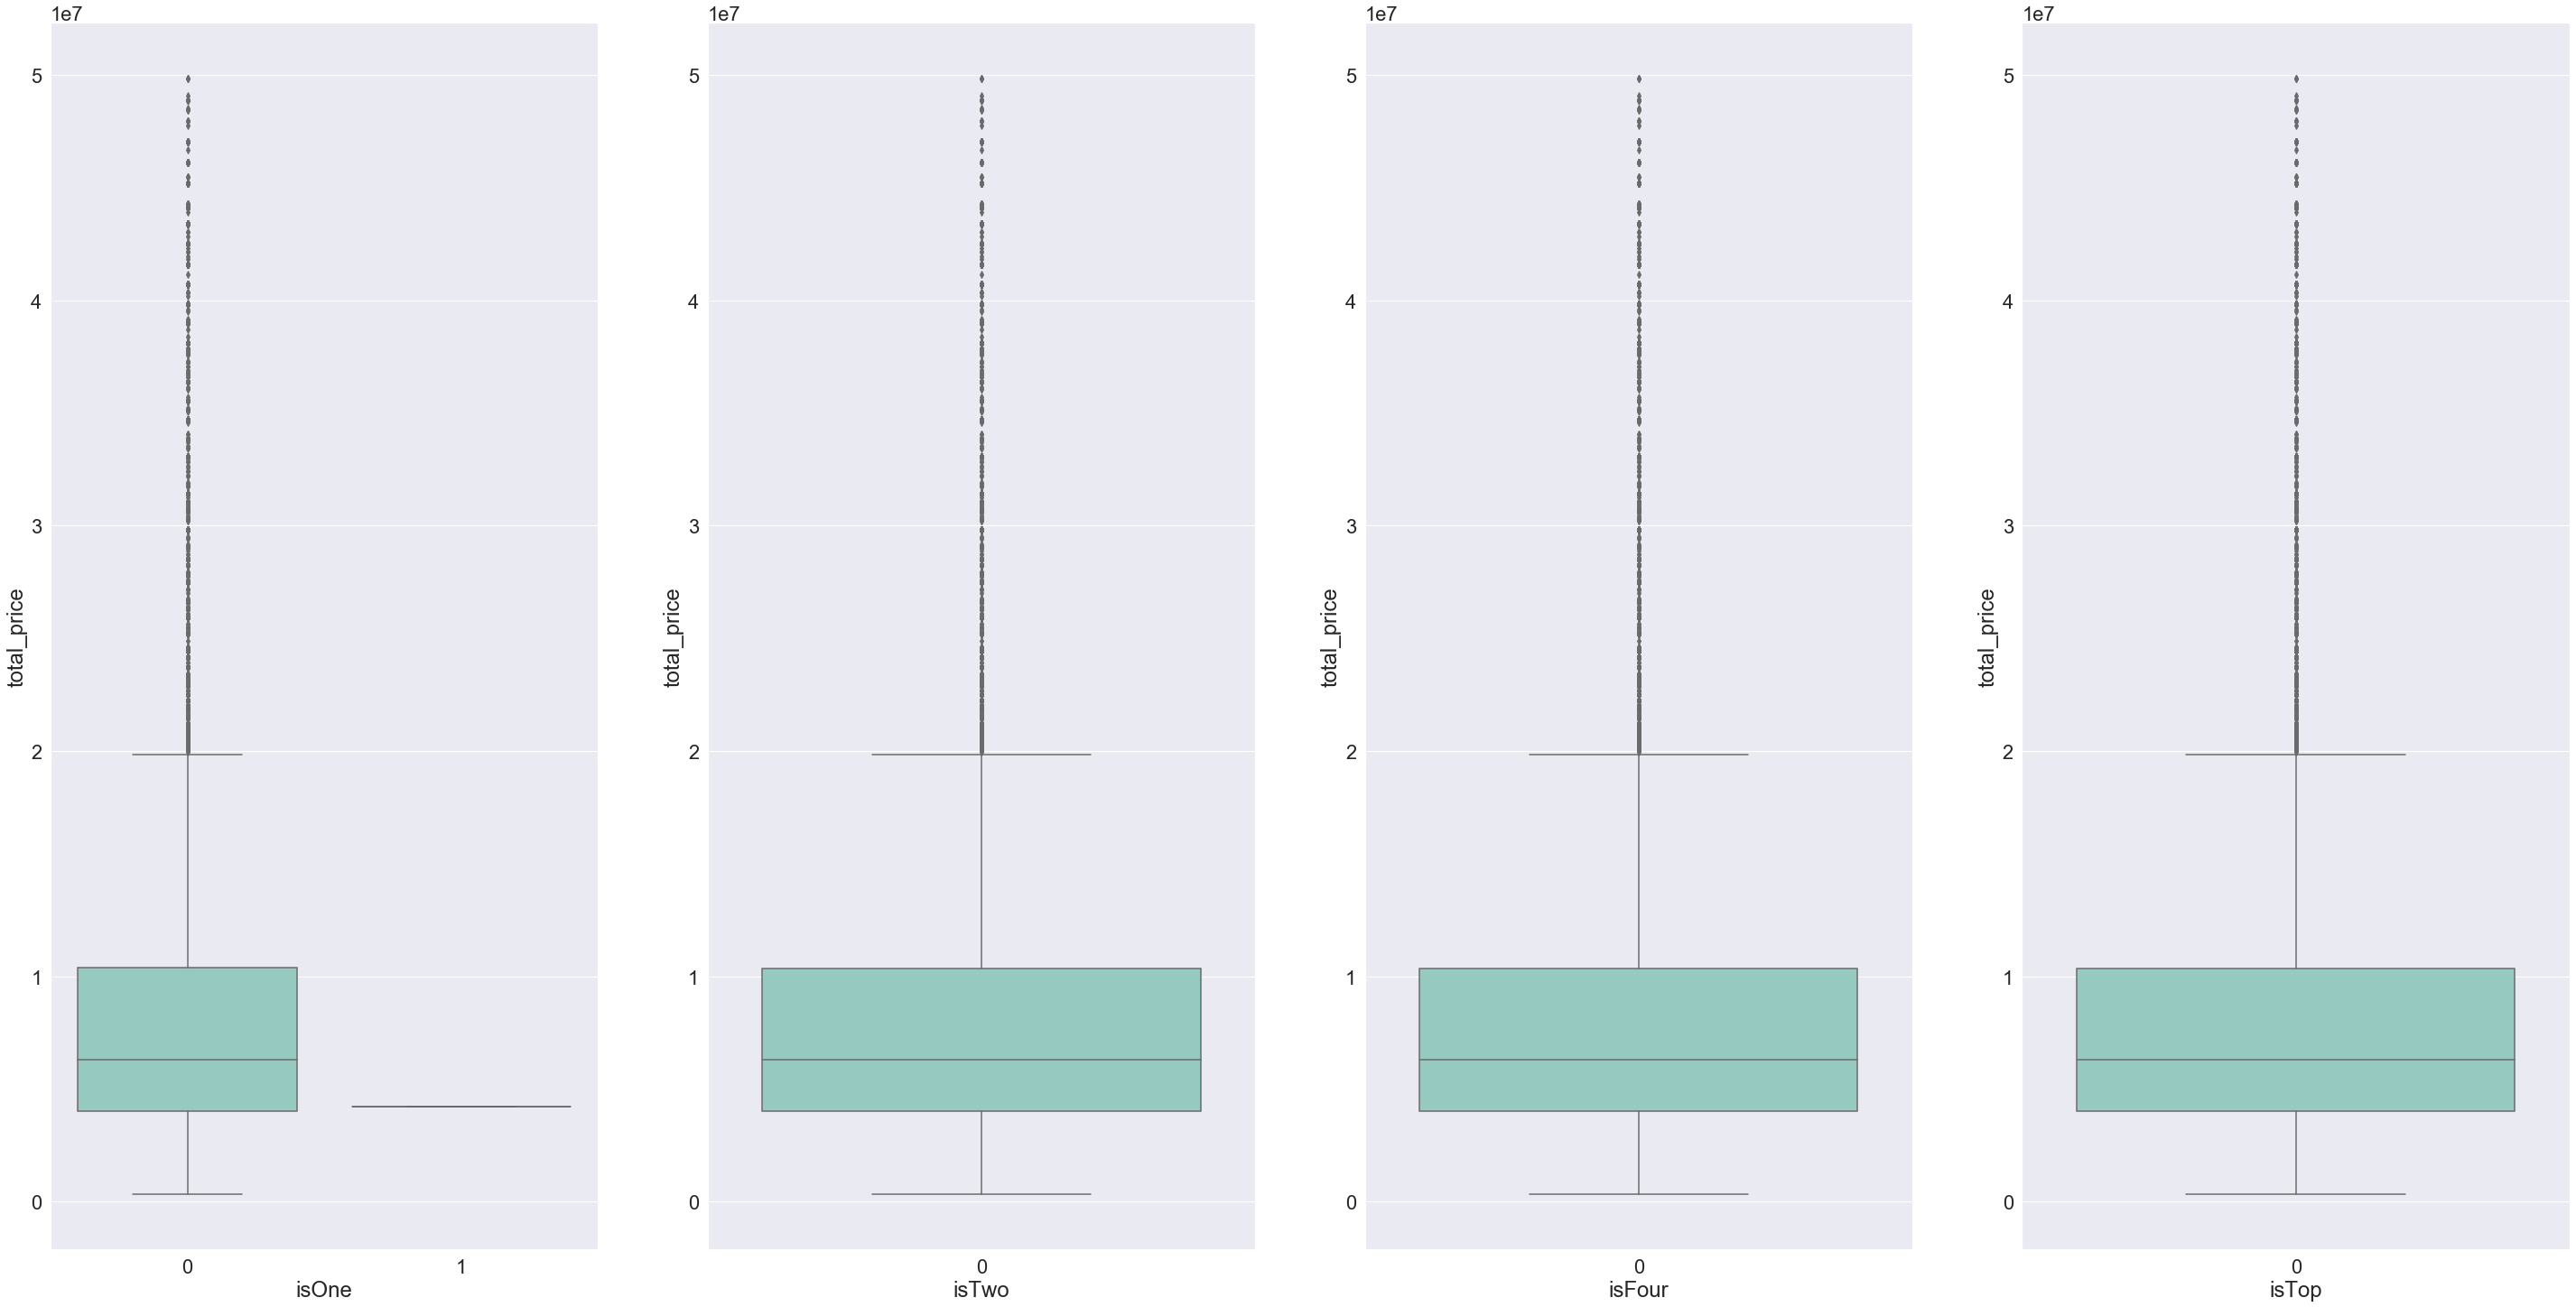

In [18]:
#查驗樓層數與總價之間的關聯
# building_type不為4
# building_use=0: 都有，1,2樓價格高於平均，頂樓低於平均，樓高2~23樓，259筆
# building_use=1: 樓高，樓高2~26樓，561筆
# building_use=2: 都有，除了1樓明顯高於平均，樓高2~29樓，38,841筆，應屬一般住宅大樓。
# building_use=3: 1樓略高於平均，2~16層樓，21筆，應屬華廈類。
# building_use=4: 4~23樓，30筆
# building_use=5: 均勻分布，價位均高於平均，2~27樓，2443筆
# building_use=6: 均勻分布,價位低於平均，2~21層樓，727筆
# building_use=7: 1,2樓明顯高於平均，4~11樓，19筆
# building_use=8: 整體略高於平均，3~24樓，746筆
# building_use=10: 整體高於平均，3~28層樓，451筆，估計很可能是商業大樓

building_use=4
df['isOne'] = ((df['txn_floor'] == 1) & (df['building_type'] != 4) & (df['building_use'] == building_use)).astype('int')
#是否2樓
df['isTwo'] = ((df['txn_floor'] == 2) & (df['building_type'] != 4) & (df['building_use'] == building_use)).astype('int')
#是否4樓
df['isFour'] = ((df['txn_floor'] == 4) & (df['building_type'] != 4) & (df['building_use'] == building_use)).astype('int')
#是否頂樓
df['isTop'] = ((df['txn_floor'] == df['total_floor']) & (df['building_type'] != 4) & (df['building_use'] == building_use)).astype('int')

plotDf=df[df['total_price']<=50000000]
plotDf=plotDf[plotDf['city']==7]
sns.set(font_scale=2)
f = plt.figure(figsize=(50,25)) 
f.add_subplot(1, 4, 1) 
sns.boxplot(x="isOne", y="total_price",data=plotDf, palette="Set3")
f.add_subplot(1, 4, 2) 
sns.boxplot(x="isTwo", y="total_price",data=plotDf, palette="Set3")
f.add_subplot(1, 4, 3) 
sns.boxplot(x="isFour", y="total_price",data=plotDf, palette="Set3")
f.add_subplot(1, 4, 4) 
sns.boxplot(x="isTop", y="total_price",data=plotDf, palette="Set3")

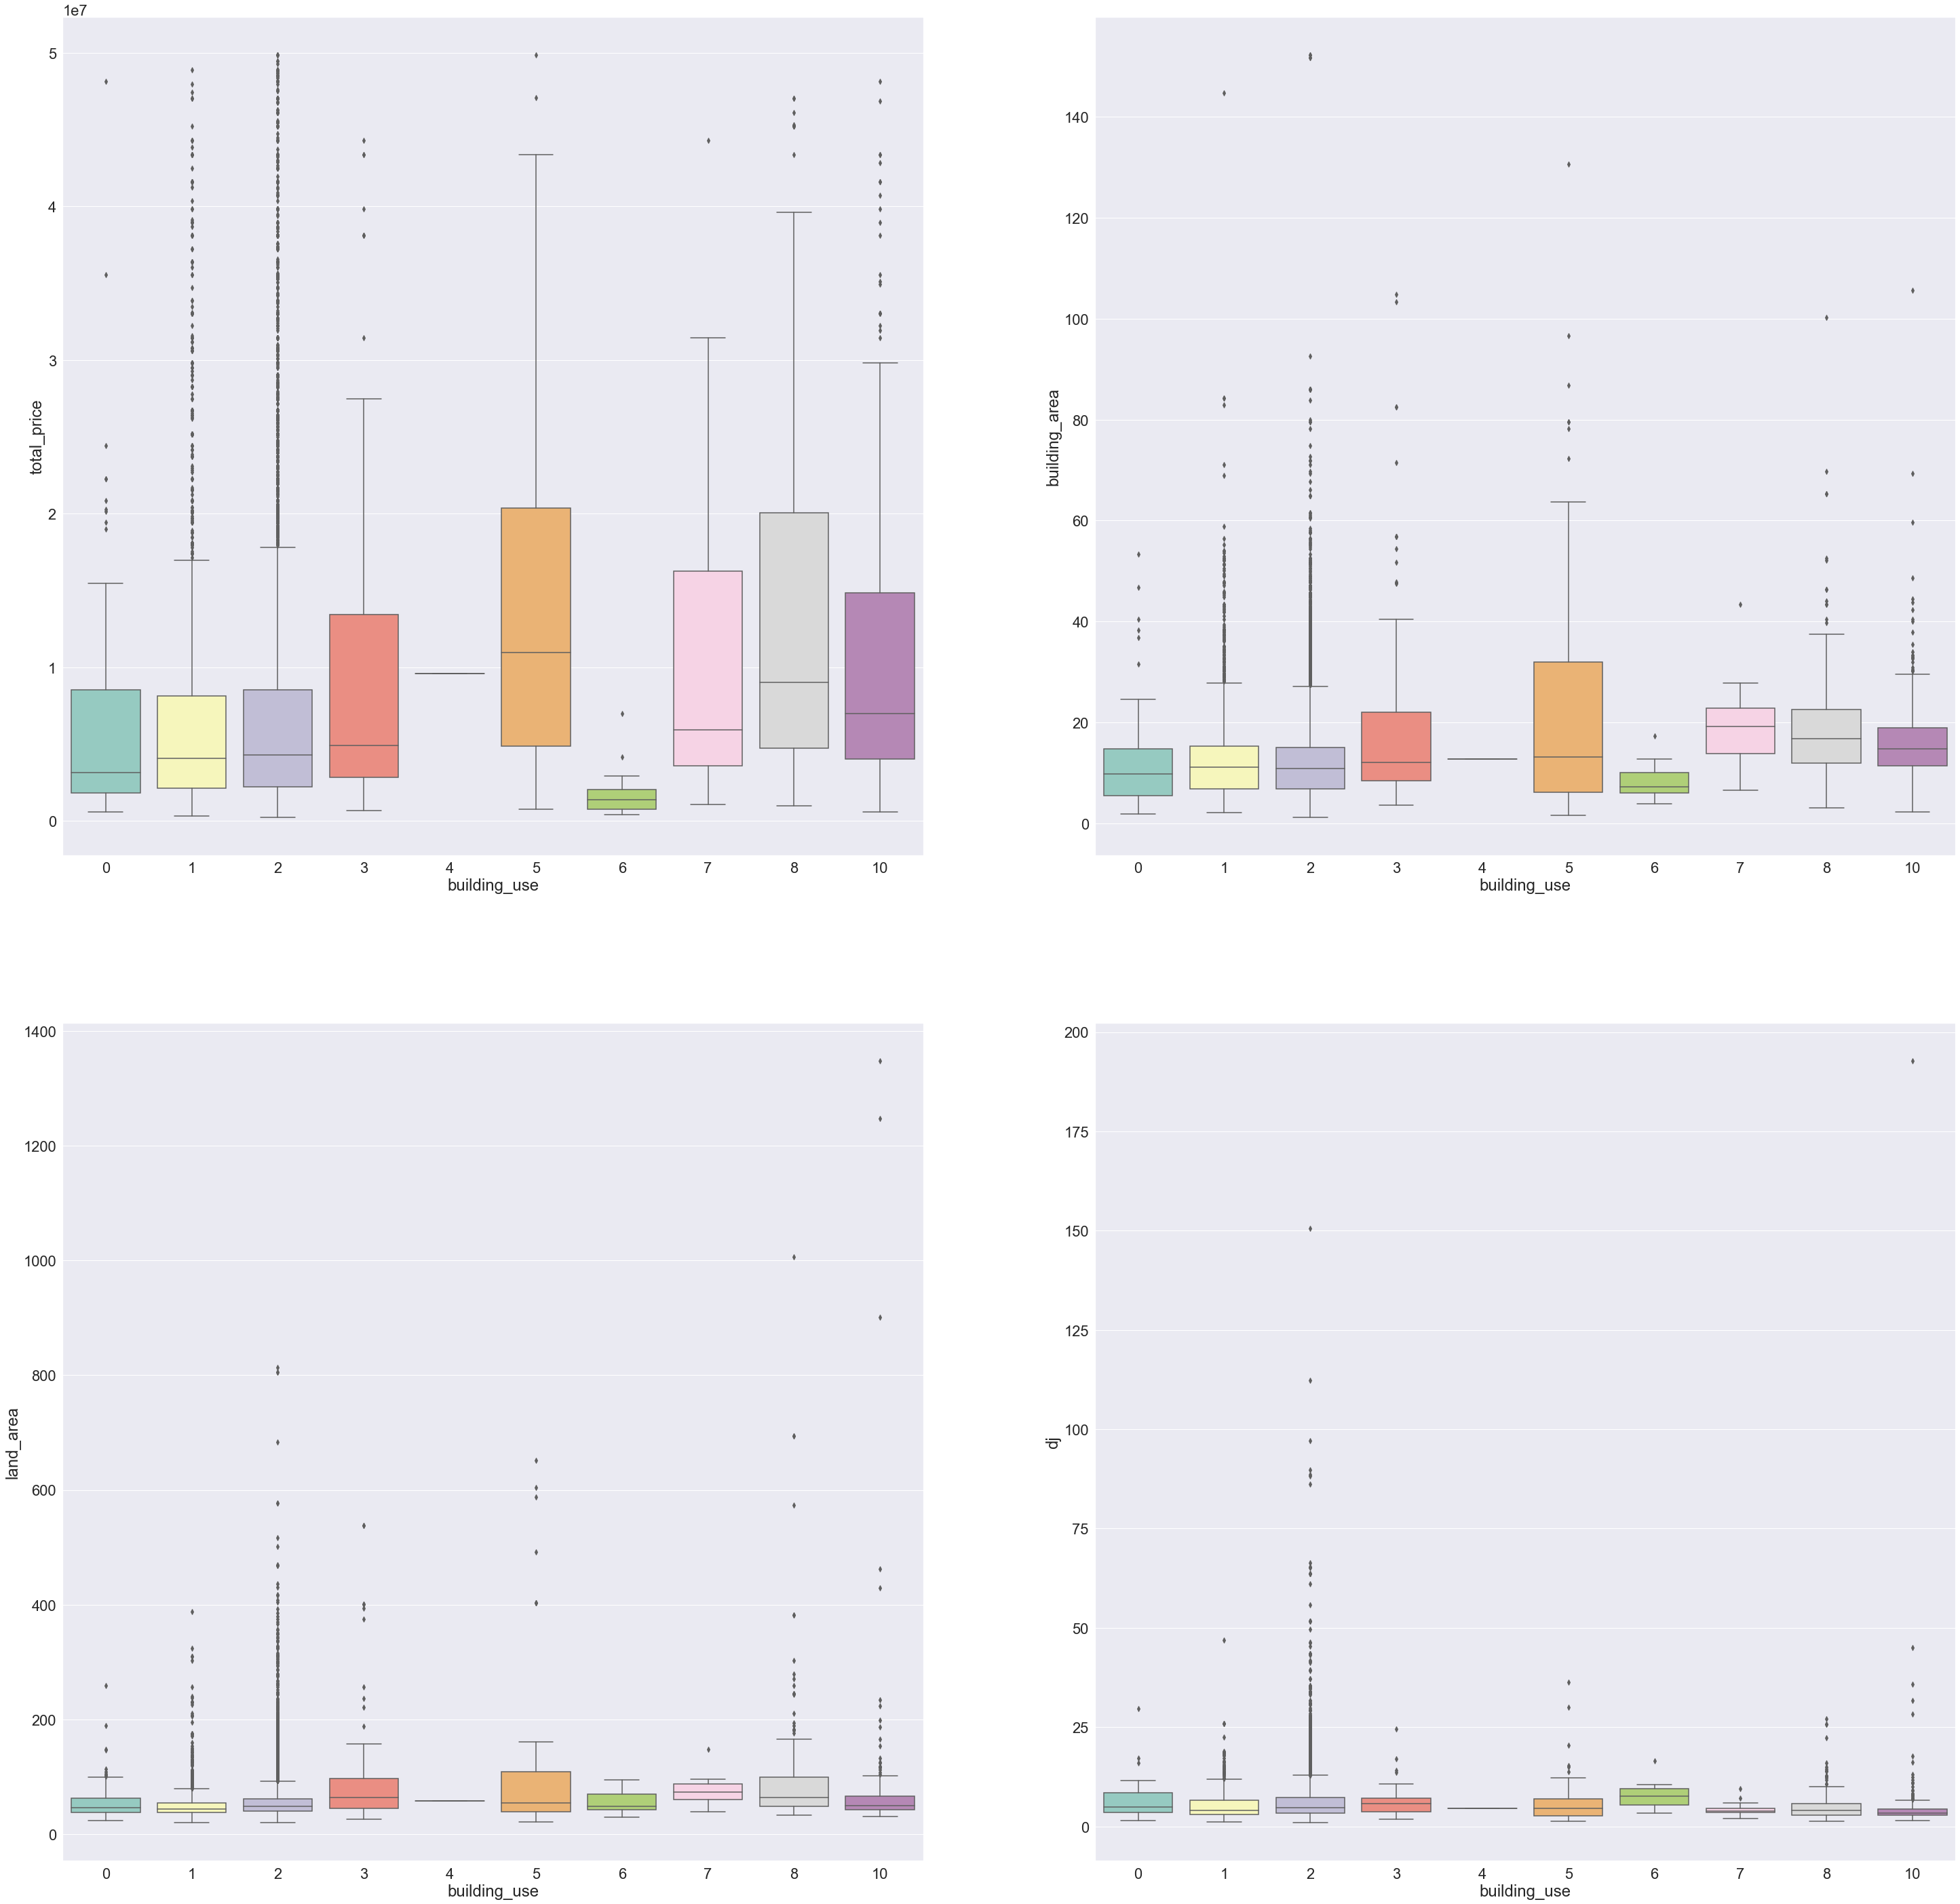

In [19]:
# building_type為4 透天
# 1~5層樓
# building_use=0: 1~5樓，110筆
# building_use=1: 1~5樓，2508筆，可能是社區型透天
# building_use=2: 1~5樓，12471筆，最多，應屬自住宅
# building_use=3: 1~5樓，98筆
# building_use=4: 3樓，1筆
# building_use=5: 1~5樓，132筆，可能是店住
# building_use=6: 2~3樓，25筆，價位偏低，地建比大，應是農舍
# building_use=7: 2~4樓，18筆
# building_use=8: 1~5樓，268筆
# building_use=10: 1~5樓，271筆

df['dj']=df['land_area']/df['building_area']
building_use=10
plotDf=df[df['building_type'] == 4]
plotDf=plotDf[plotDf['total_price']<=50000000]
#plotDf=plotDf[plotDf['city']==7]
sns.set(font_scale=2)
f = plt.figure(figsize=(50,50)) 
f.add_subplot(2, 2, 1) 
sns.boxplot(x="building_use", y="total_price",data=plotDf, palette="Set3")
f.add_subplot(2, 2, 2) 
sns.boxplot(x="building_use", y="building_area",data=plotDf, palette="Set3")
f.add_subplot(2, 2, 3) 
sns.boxplot(x="building_use", y="land_area",data=plotDf, palette="Set3")
f.add_subplot(2, 2, 4) 
sns.boxplot(x="building_use", y="dj",data=plotDf, palette="Set3")

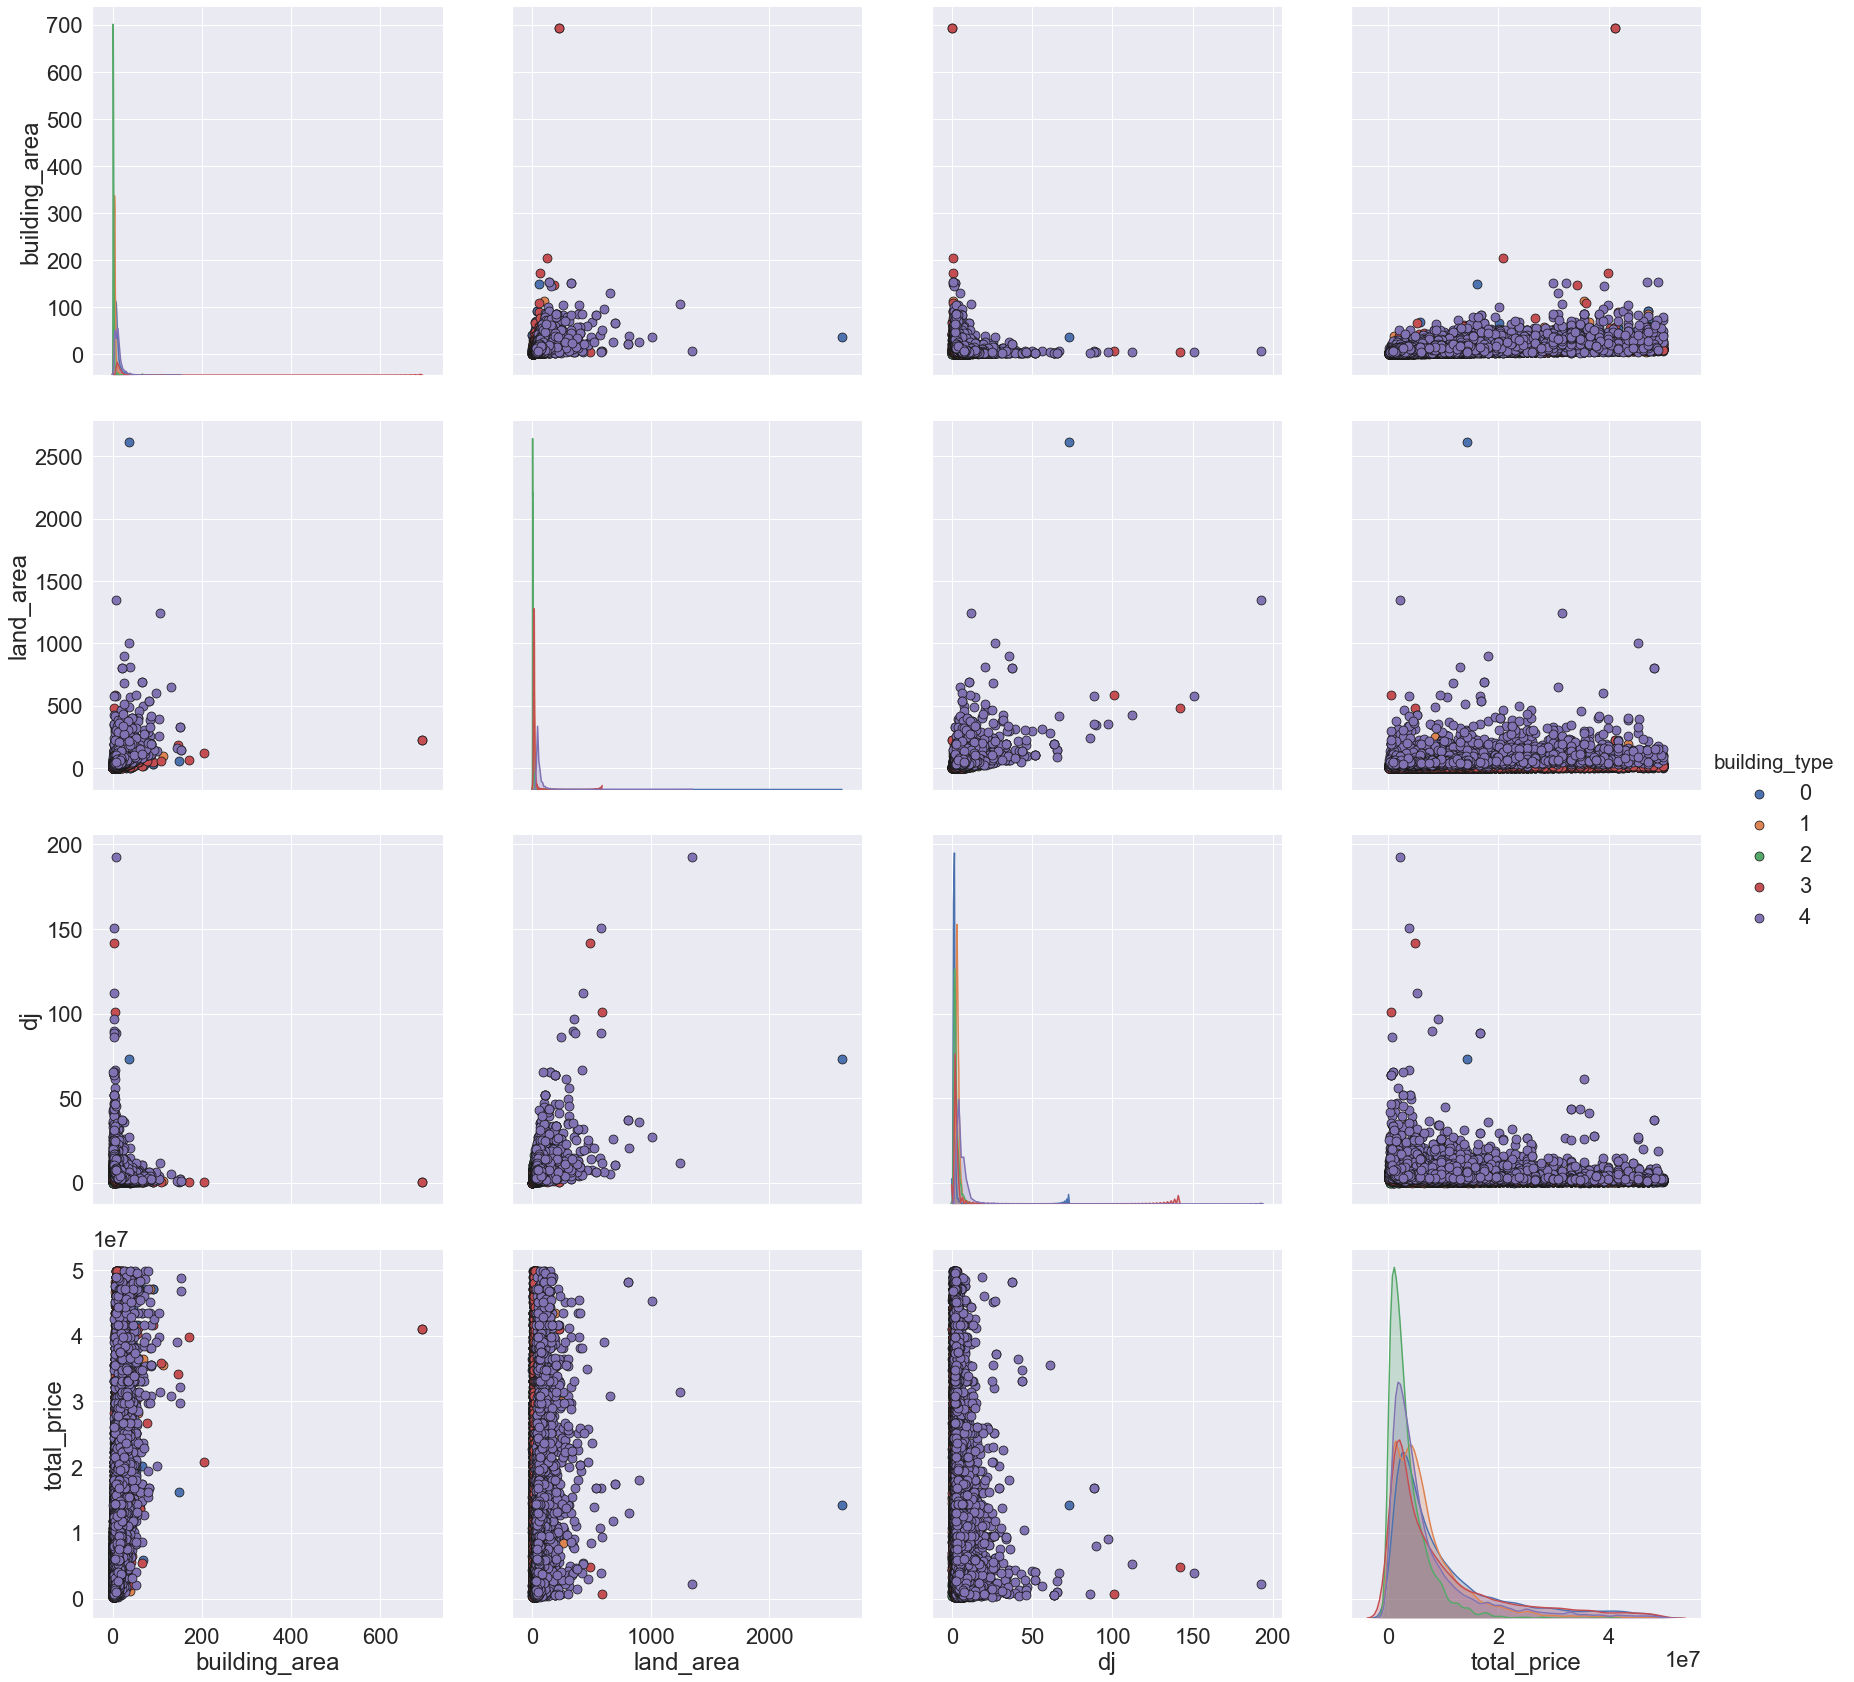

In [20]:
#地建比與價格之間的關聯性分析
#地建比明顯與總價呈負相關，建議加入本特徵
#plotDf=plotDf[plotDf['city']==7]
plotDf=df[df['total_price']<=50000000]
#plotDf=plotDf[plotDf['building_type']==4]
sns.set(font_scale=2)
sns.pairplot(plotDf, 
             vars = ['building_area','land_area','dj','total_price'], diag_kind = 'kde', hue='building_type',
             plot_kws = {'alpha': 1, 's': 80, 'edgecolor': 'k'},
             size = 6);

In [21]:
#查看building_type分布
df['building_type'].value_counts()

4    15902
0    15691
1    15049
3    10536
2     2822
Name: building_type, dtype: int64

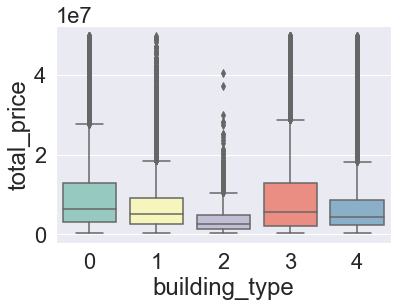

In [22]:
# building_type比較
# 0: 11~29樓，15,691筆，商業型
# 1: 1~22樓,15,049筆，住宅型
# 2: 2~28樓,2,822筆，?
# 3: 2~10樓,10536筆，華廈型
# 4: 1~5樓,15902筆，透天型
plotDf=df[df['total_price']<=50000000]
#plotDf=plotDf[plotDf['city']==7]
sns.set(font_scale=2)
sns.boxplot(x="building_type", y="total_price",data=plotDf, palette="Set3")

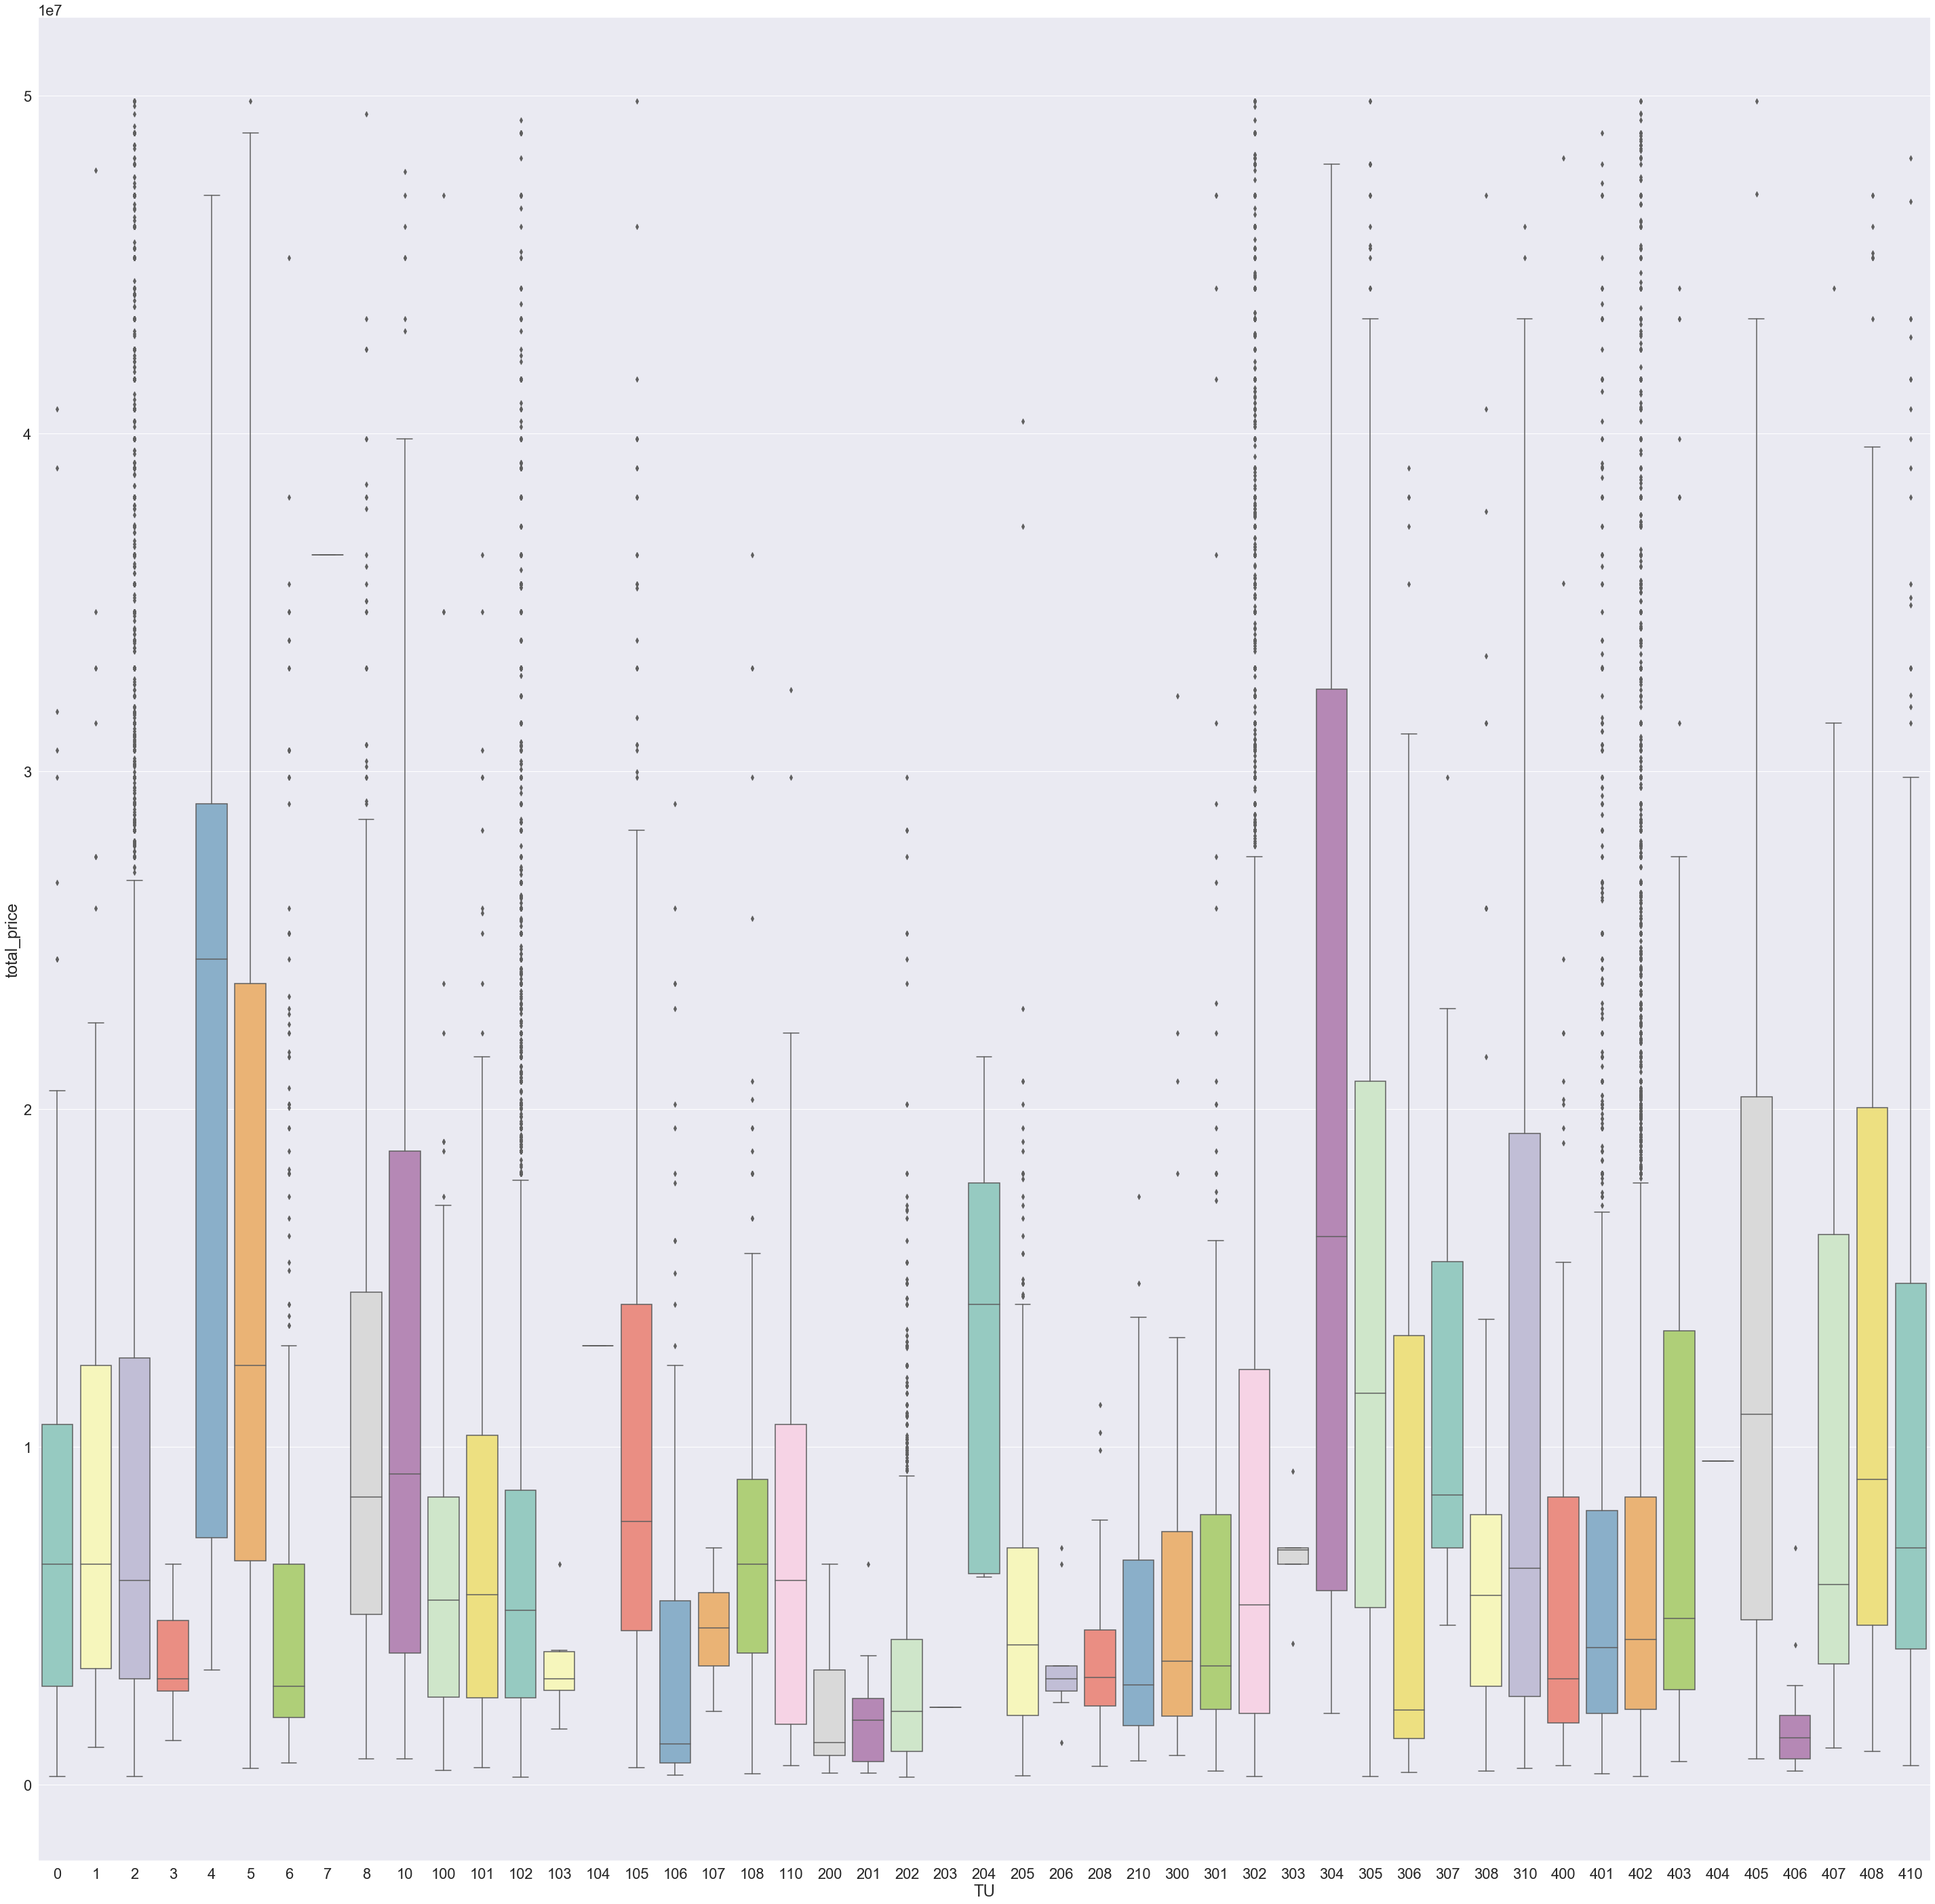

In [23]:
#以Type和Use組合新特徵
#Use=4應屬商業用途，價格均較同Type為高，1屬住家型，4屬透天型，故少有商業用途。
#建議加上此OneHot特徵
df['TU']=df['building_type']*100+df['building_use']
plotDf=df[df['total_price']<=50000000]
f = plt.figure(figsize=(50,50)) 
sns.set(font_scale=2)
sns.boxplot(x="TU", y="total_price",data=plotDf, palette="Set3")

In [24]:
#查看building_material分布
df['building_material'].value_counts()

8     52609
1      6372
10      462
7       375
9       167
3         7
11        4
5         2
4         2
Name: building_material, dtype: int64

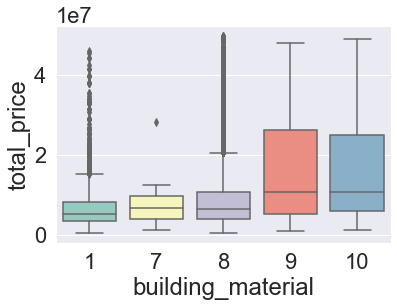

In [25]:
# building_material比較
# 1: 1~7樓，375筆，
# 3: 5~11樓,7筆，
# 4: 4~5樓,2筆，
# 5: 2樓,2筆，
# 7: 1~6樓,375筆，
# 8: 1~29樓,52609筆，
# 9: 1~26樓,167筆，
# 10: 2~29樓,462筆，
# 11: 1~5樓,4筆，應為同一建案
plotDf=df[df['total_price']<=50000000]
plotDf=plotDf[plotDf['city']==7]
sns.set(font_scale=2)
sns.boxplot(x="building_material", y="total_price",data=plotDf, palette="Set3")

In [26]:
#其他關聯性1
#City的不同就已經代表了所有"率"的不同，建議不需要再列入特徵，列了反而會出事 (似乎有刻意加入雜質)
#建議加入city特徵就好
rateTest=df[df['city']==7]
rateTest[['doc_rate','master_rate','bachelor_rate','highschool_rate',
          'jobschool_rate','junior_rate','elementary_rate','born_rate',
          'death_rate','marriage_rate','divorce_rate']].describe()


doc_rate   master_rate  bachelor_rate  highschool_rate  \
count  1.966400e+04  19664.000000   19664.000000     19664.000000   
mean   3.518093e-03      0.048779       0.216042         0.310976   
std    4.989432e-07      0.000005       0.000012         0.000142   
min    3.448131e-03      0.048064       0.214334         0.310975   
25%    3.518097e-03      0.048779       0.216042         0.310975   
50%    3.518097e-03      0.048779       0.216042         0.310975   
75%    3.518097e-03      0.048779       0.216042         0.310975   
max    3.518097e-03      0.048779       0.216042         0.330870   

       jobschool_rate   junior_rate  elementary_rate     born_rate  \
count    19664.000000  19664.000000     19664.000000  19664.000000   
mean         0.106792      0.195193         0.118700      7.940146   
std          0.000038      0.000092         0.000006      0.020467   
min          0.101413      0.182317         0.118700      7.940000   
25%          0.106792      0.195193         0.118700      7.940000   
50%          0.106792      0.195193         0.118700      7.940000   
75%          0.106792      0.195193         0.118700      7.940000   
max          0.106792      0.195193         0.119554     10.810000   

         death_rate  marriage_rate  divorce_rate  
count  19664.000000   19664.000000  19664.000000  
mean       5.929997       6.110031      2.500010  
std        0.000428       0.004350      0.001355  
min        5.870000       6.110000      2.500000  
25%        5.930000       6.110000      2.500000  
50%        5.930000       6.110000      2.500000  
75%        5.930000       6.110000      2.500000  
max        5.930000       6.720000      2.690000

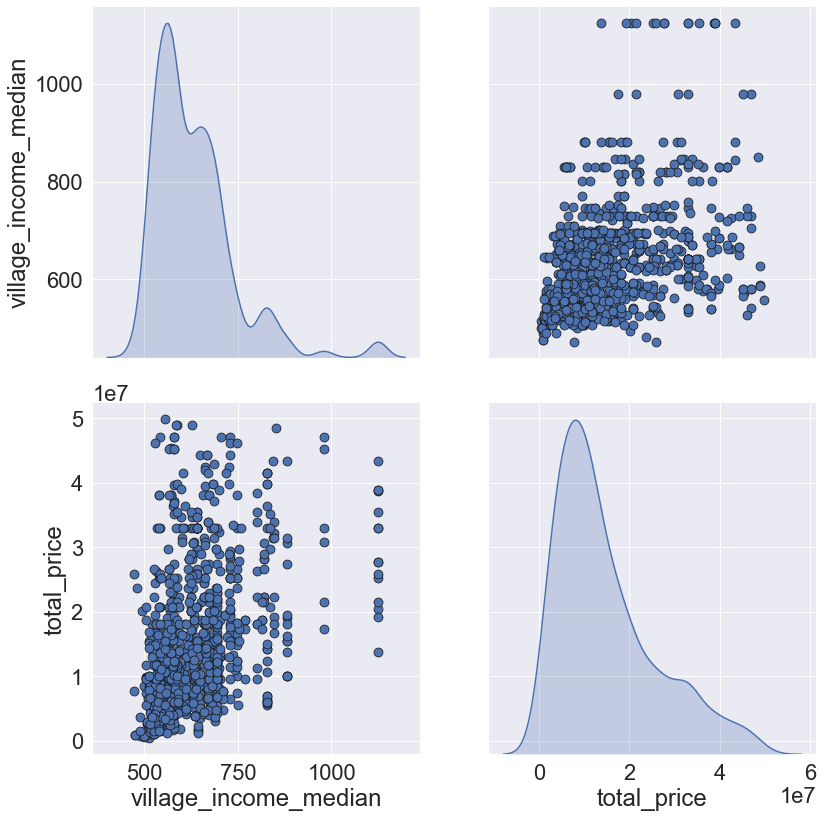

In [27]:
#里平均收入有正相關，須好好補缺失值，且此欄位結合其他特徵應足以表現里的不同，故不需要用CTV或經緯度特徵

plotDf=df[df['total_price']<=50000000]
plotDf=plotDf[plotDf['city']==7]
plotDf=plotDf[plotDf['building_type']==4]
sns.set(font_scale=2)
sns.pairplot(plotDf, 
             vars = ['village_income_median','total_price'''], diag_kind = 'kde',
             plot_kws = {'alpha': 1, 's': 80, 'edgecolor': 'k'},
             size = 6);

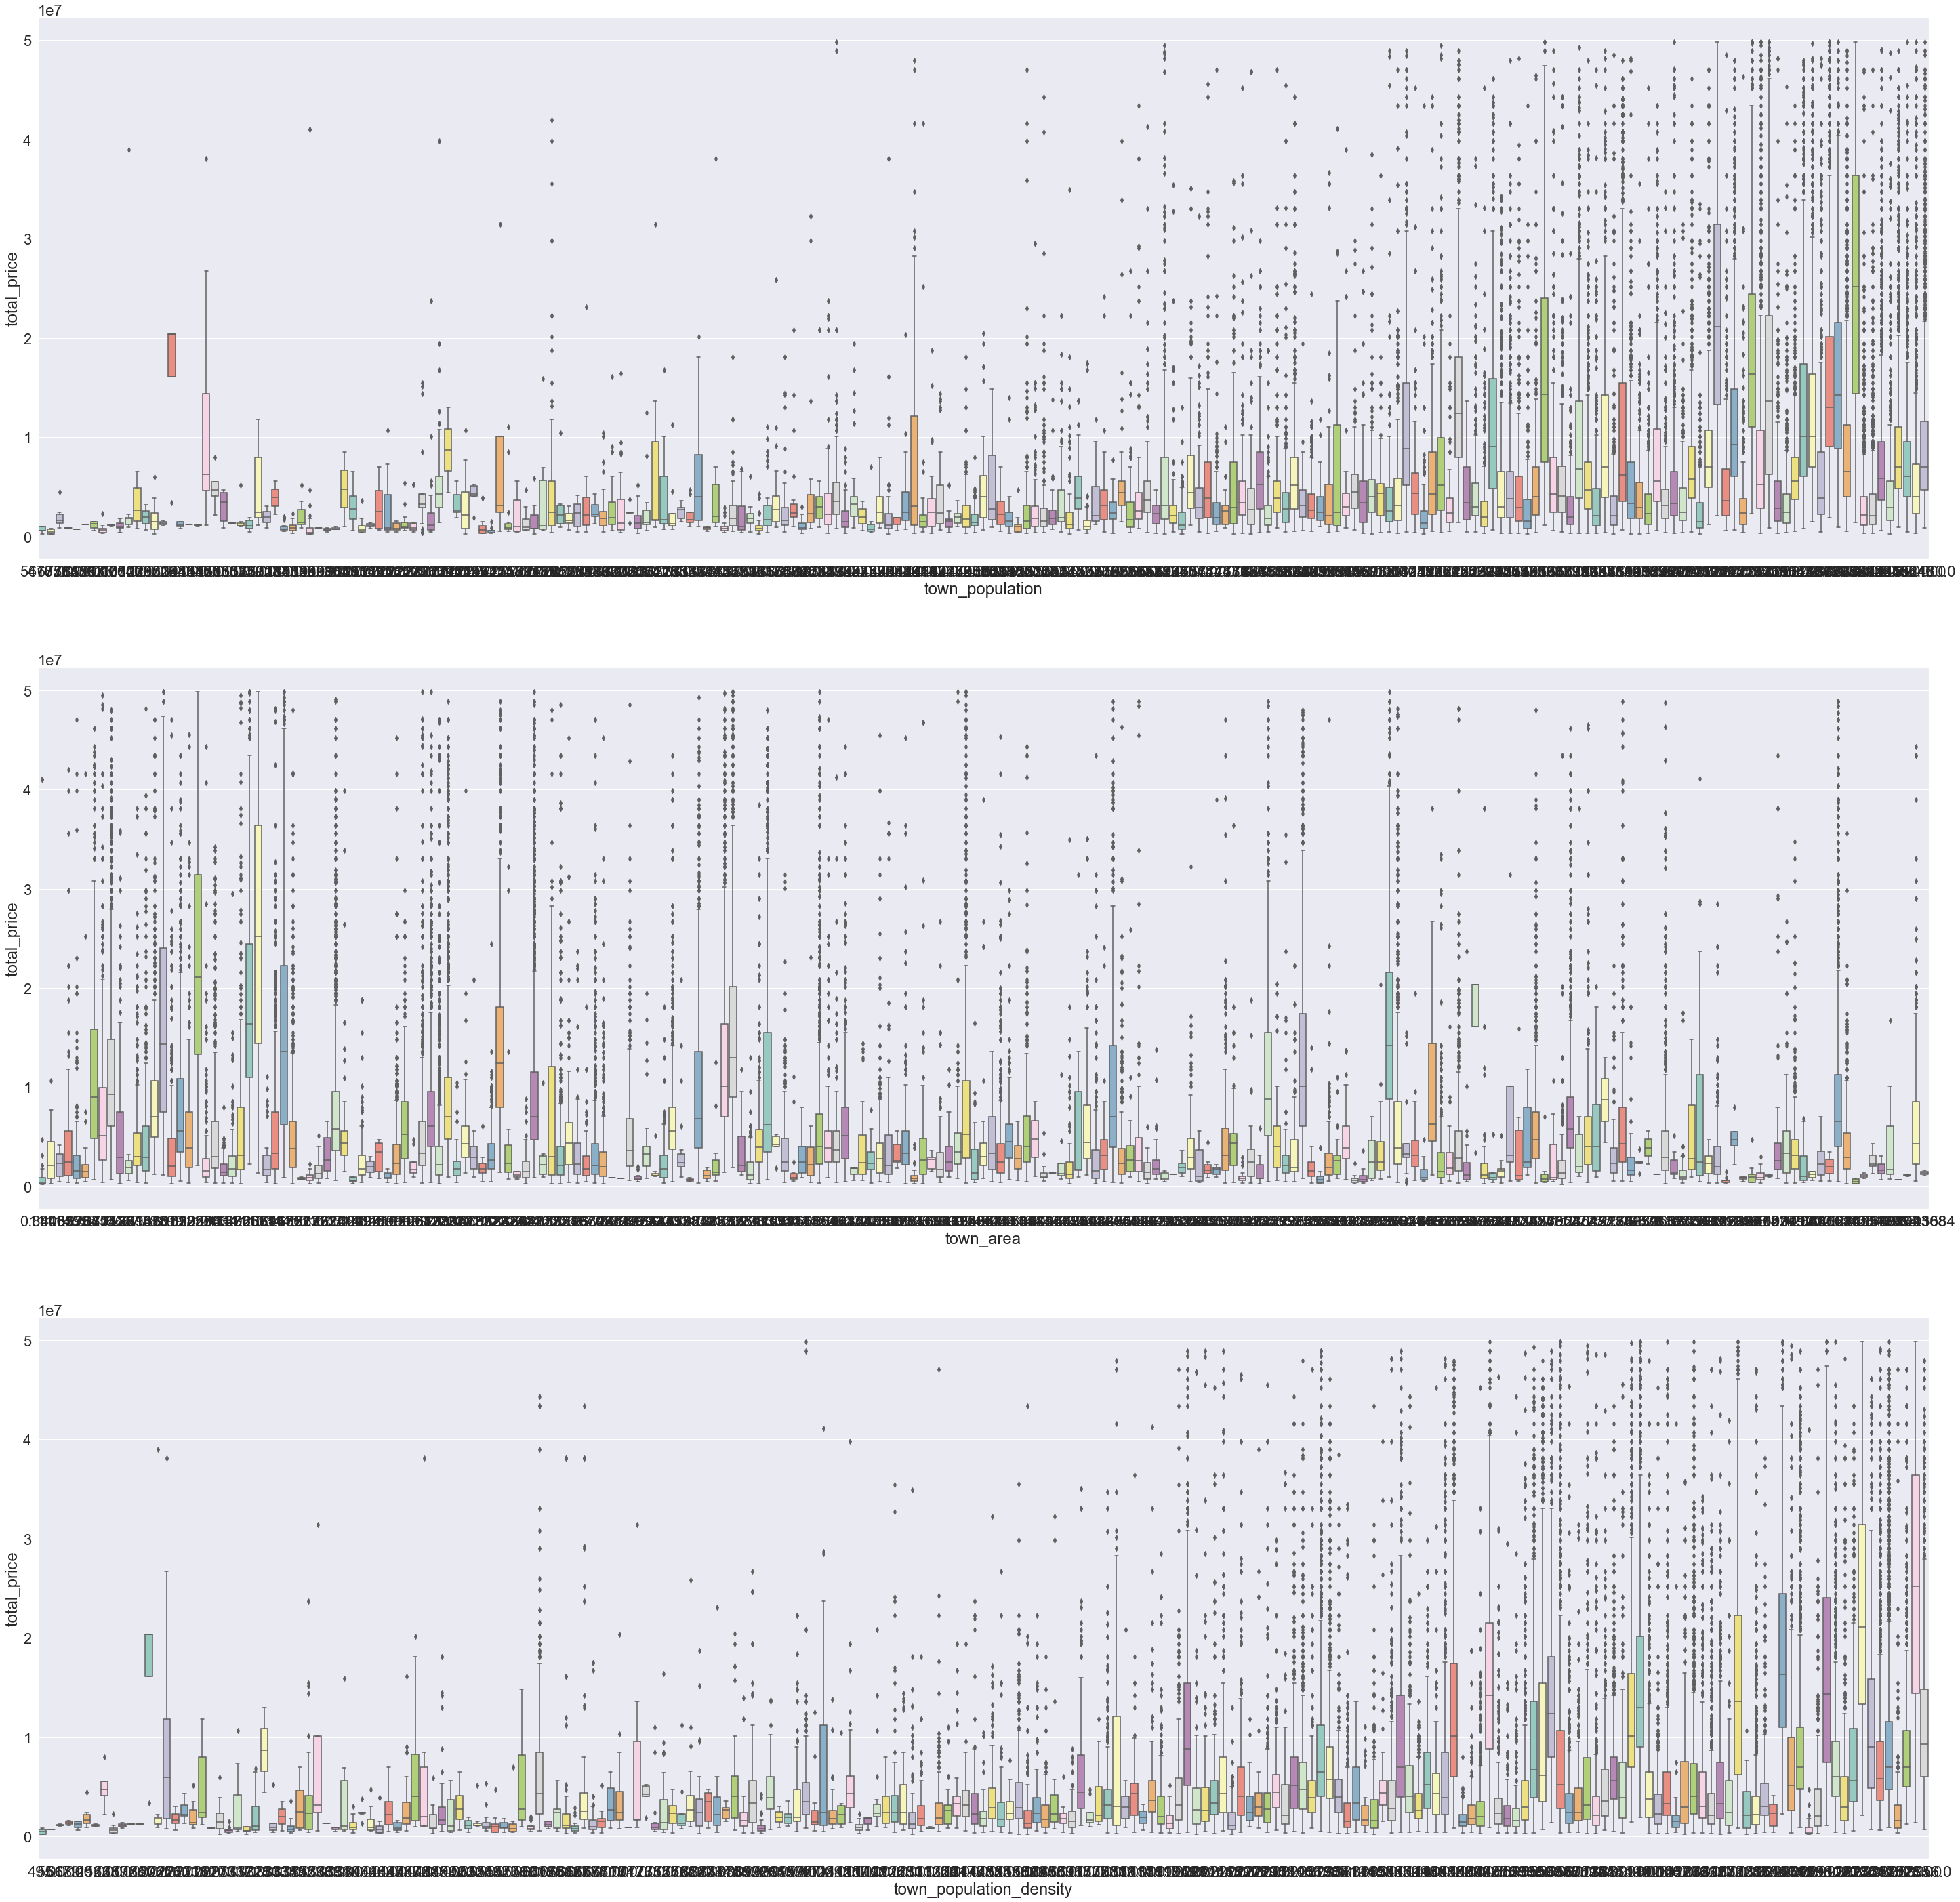

In [28]:
#鄉鎮特徵，包含town_population,town_area,town_population_density
#其中town_population與town_population_density和價格有正相關
#建議都納入
plotDf=df[df['total_price']<=50000000]
sns.set(font_scale=2)
f = plt.figure(figsize=(50,50)) 
f.add_subplot(3,1, 1) 
sns.boxplot(x="town_population", y="total_price",data=plotDf, palette="Set3")
f.add_subplot(3, 1, 2) 
sns.boxplot(x="town_area", y="total_price",data=plotDf, palette="Set3")
f.add_subplot(3, 1, 3) 
sns.boxplot(x="town_population_density", y="total_price",data=plotDf, palette="Set3")



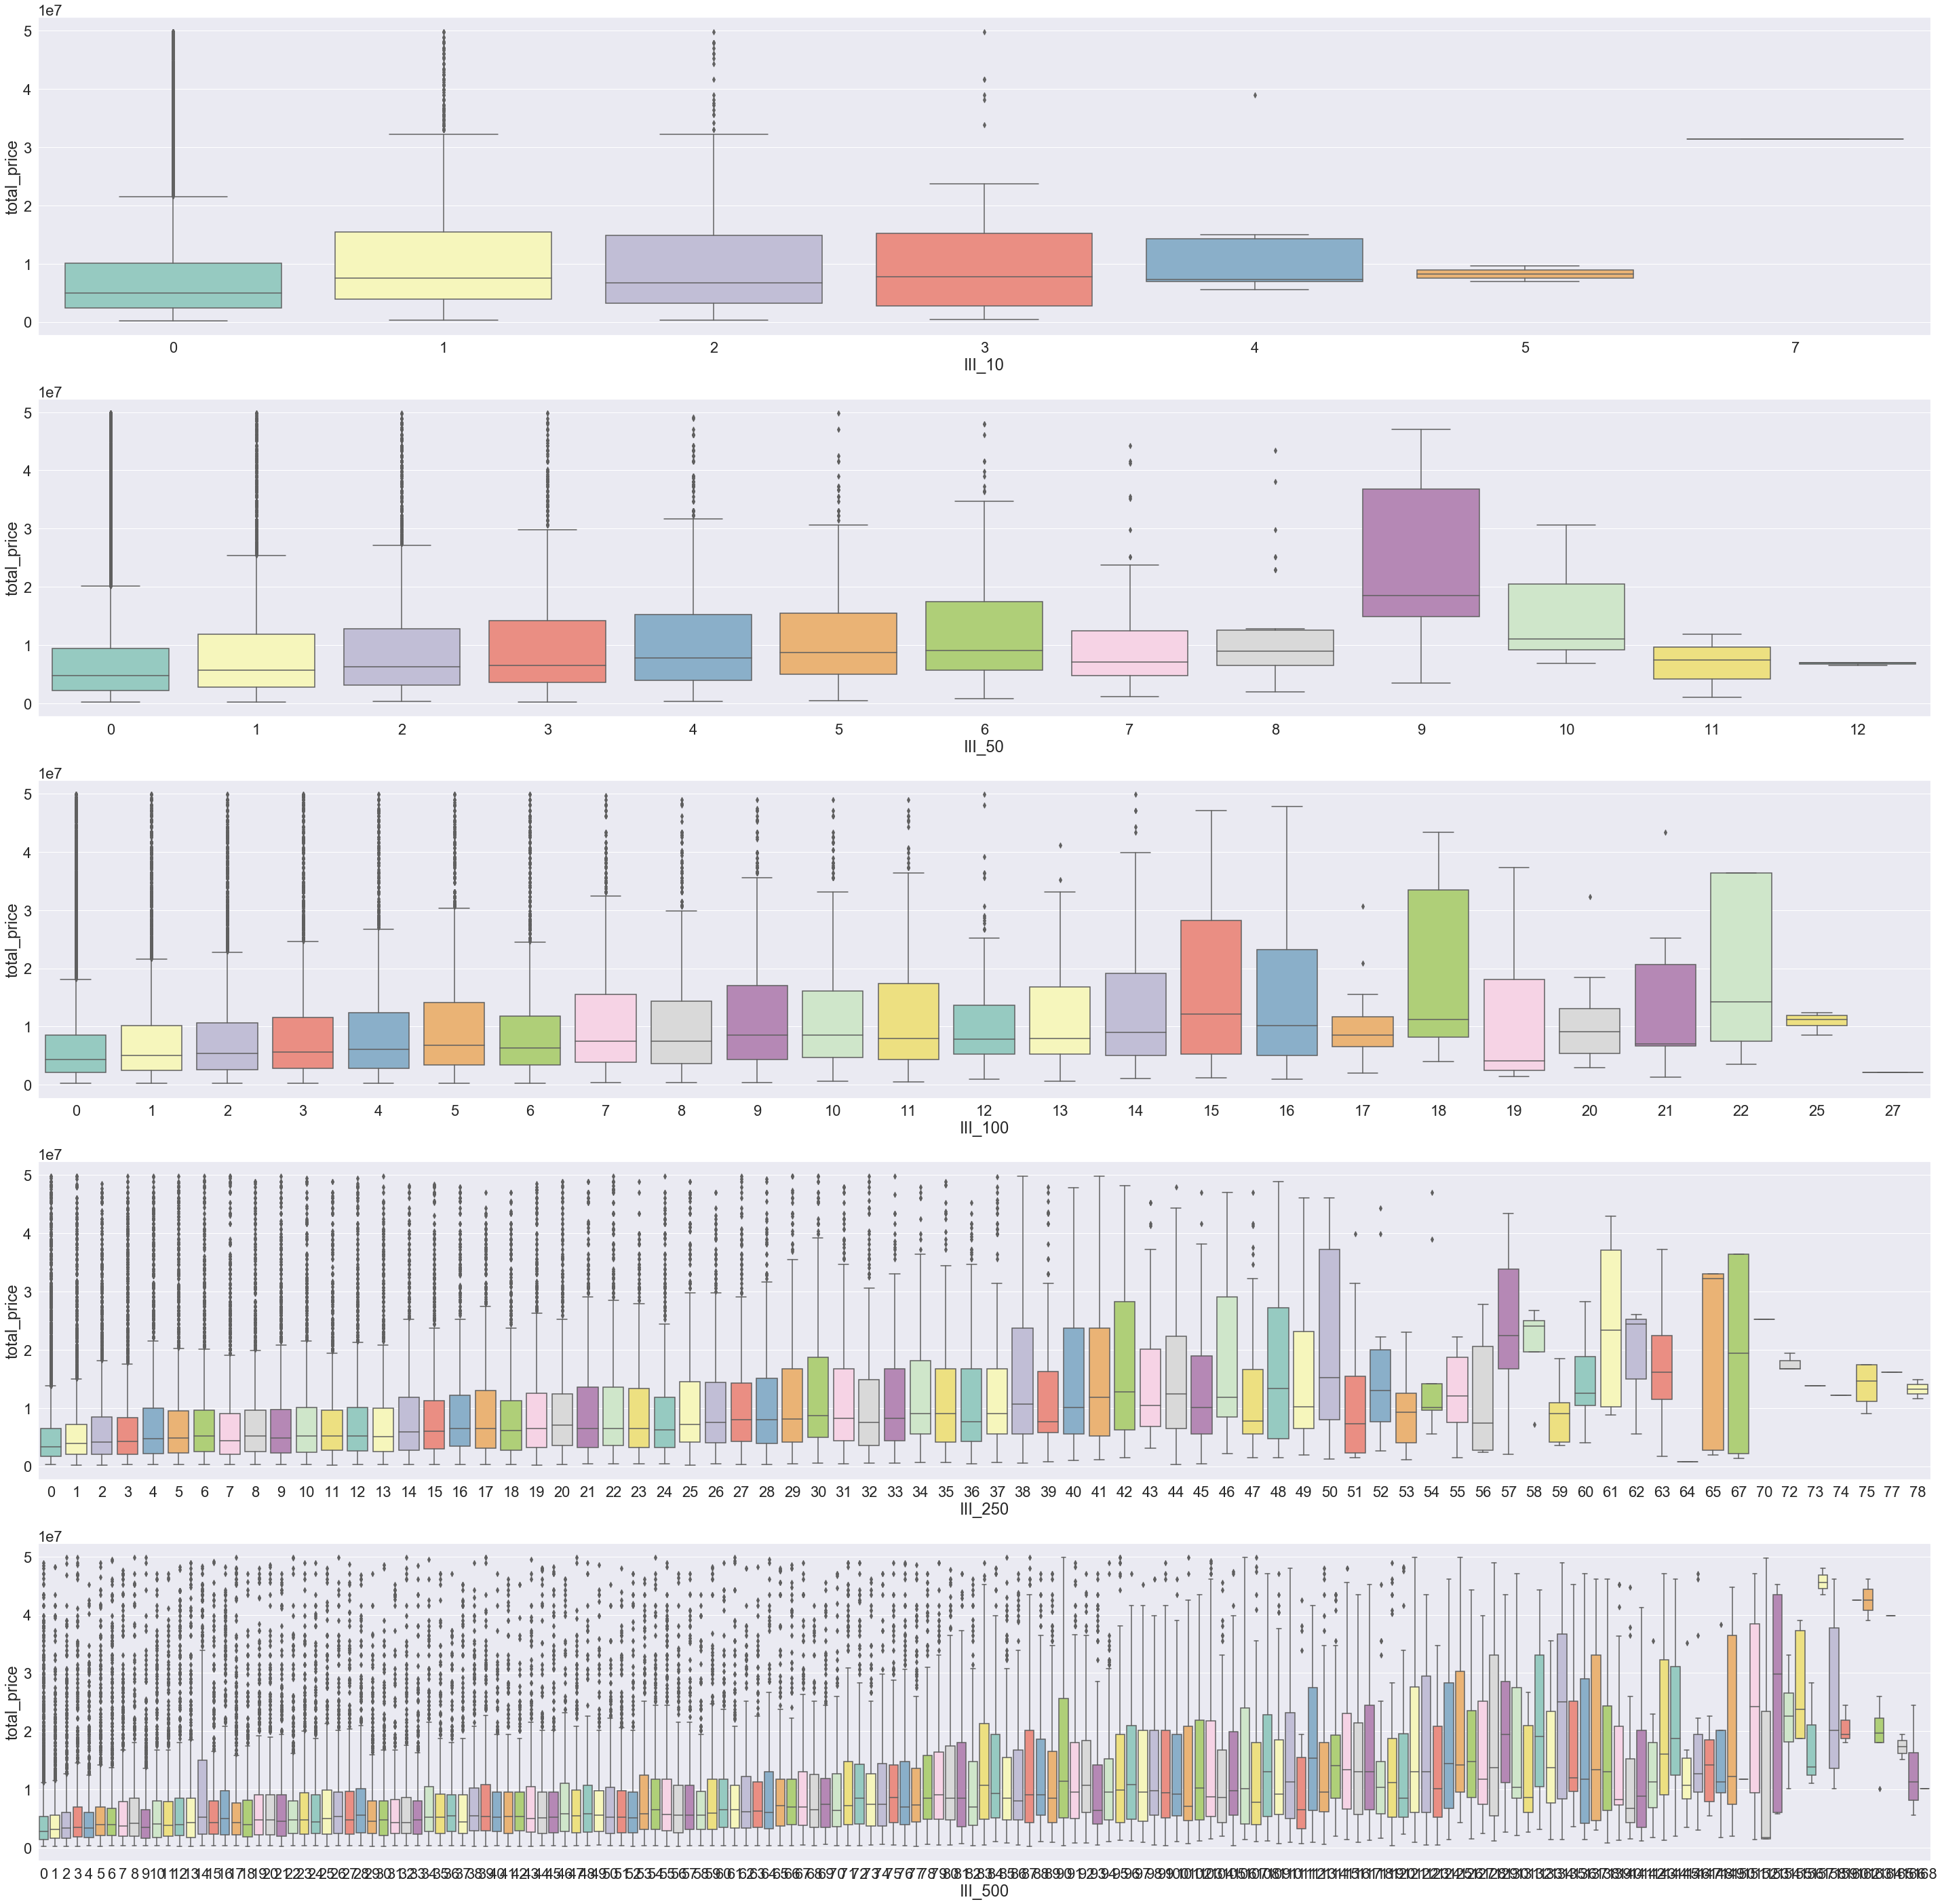

In [29]:
#I~XIV特徵，數量大致與總價成正比，建議這些特徵就留著吧。
plotDf=df[df['total_price']<=50000000]
sns.set(font_scale=2)
f = plt.figure(figsize=(50,50)) 
f.add_subplot(5,1, 1) 
sns.boxplot(x="III_10", y="total_price",data=plotDf, palette="Set3")
f.add_subplot(5, 1, 2) 
sns.boxplot(x="III_50", y="total_price",data=plotDf, palette="Set3")
f.add_subplot(5, 1, 3) 
sns.boxplot(x="III_100", y="total_price",data=plotDf, palette="Set3")
f.add_subplot(5, 1, 4) 
sns.boxplot(x="III_250", y="total_price",data=plotDf, palette="Set3")
f.add_subplot(5, 1, 5) 
sns.boxplot(x="III_500", y="total_price",data=plotDf, palette="Set3")
#f.add_subplot(8, 1, 6) 
#sns.boxplot(x="I_1000", y="total_price",data=plotDf, palette="Set3")
#f.add_subplot(8, 1, 7) 
#sns.boxplot(x="I_5000", y="total_price",data=plotDf, palette="Set3")
#f.add_subplot(8, 1, 8) 
#sns.boxplot(x="I_10000", y="total_price",data=plotDf, palette="Set3")

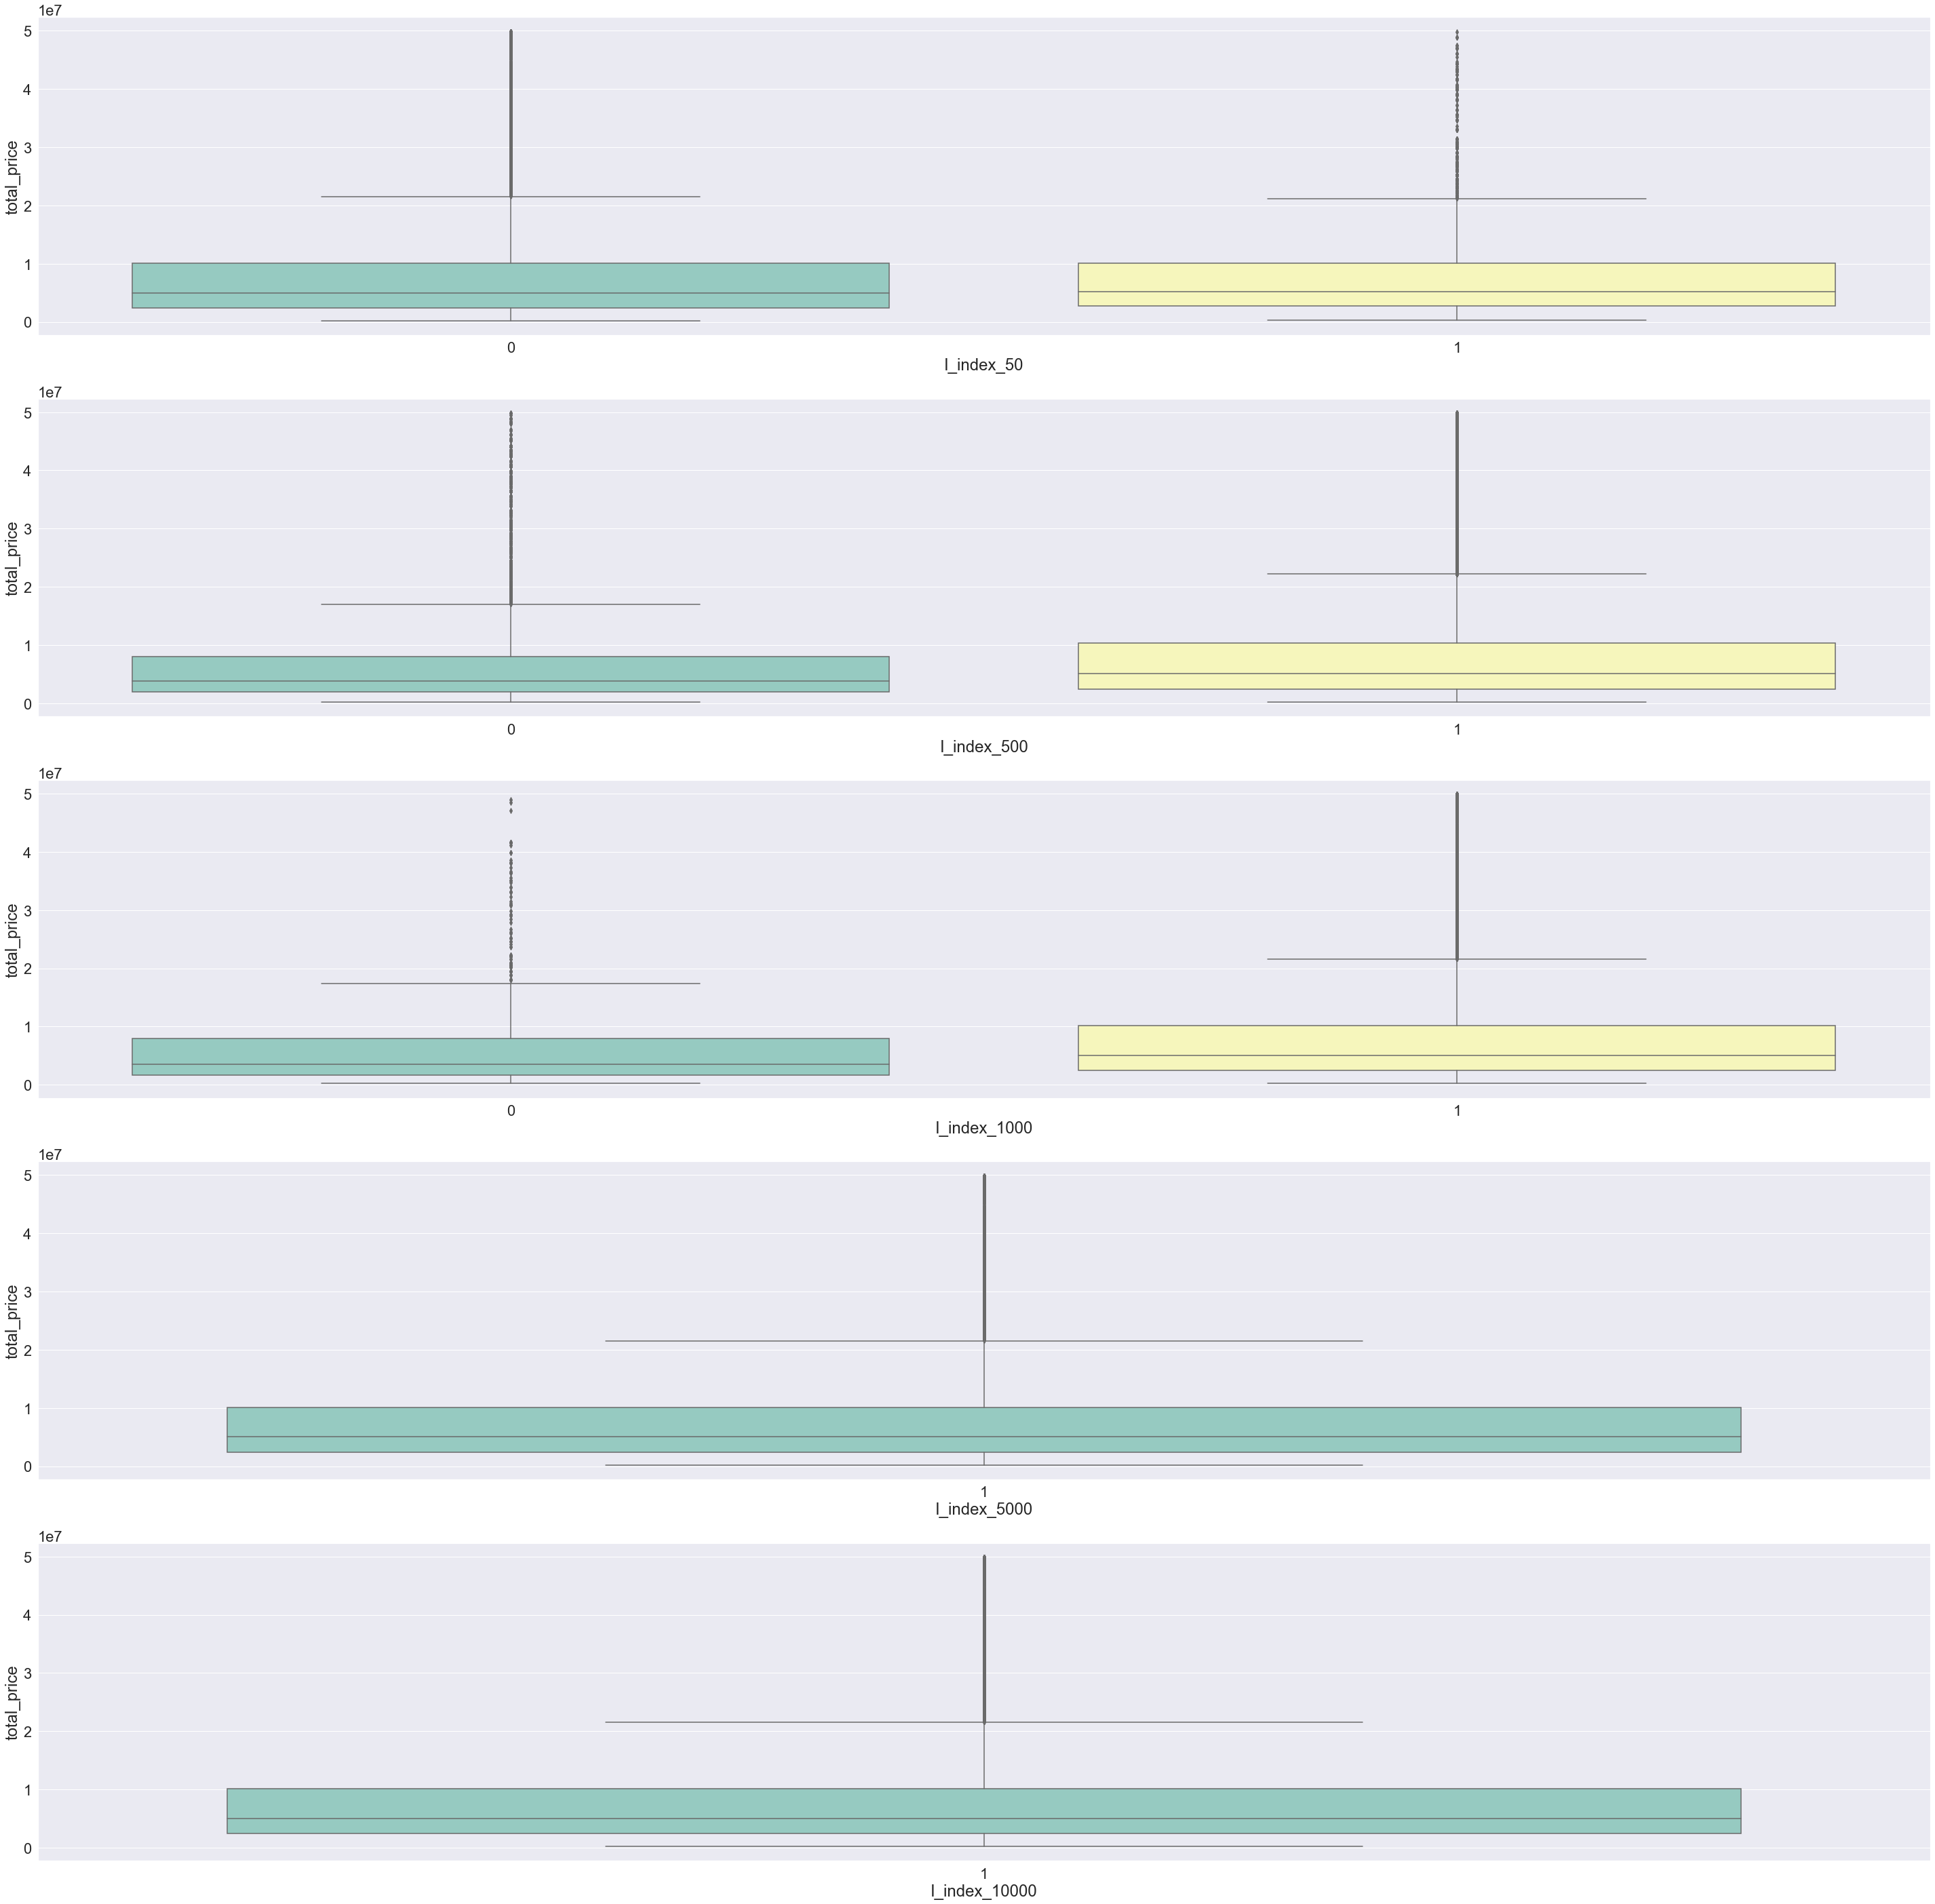

In [30]:
#I~XIV Index特徵，10000以上應該沒影響性，都取50~1000就好。
plotDf=df[df['total_price']<=50000000]
sns.set(font_scale=2)
f = plt.figure(figsize=(50,50)) 
f.add_subplot(5,1, 1) 
sns.boxplot(x="I_index_50", y="total_price",data=plotDf, palette="Set3")
f.add_subplot(5, 1, 2) 
sns.boxplot(x="I_index_500", y="total_price",data=plotDf, palette="Set3")
f.add_subplot(5, 1, 3) 
sns.boxplot(x="I_index_1000", y="total_price",data=plotDf, palette="Set3")
f.add_subplot(5, 1, 4) 
sns.boxplot(x="I_index_5000", y="total_price",data=plotDf, palette="Set3")
f.add_subplot(5, 1, 5) 
sns.boxplot(x="I_index_10000", y="total_price",data=plotDf, palette="Set3")

In [31]:
#缺失值分析
#檢查缺失值
def checkNull(checkDf):
    a=checkDf.isnull().sum()
    i=0
    while i<len(a):
        valueA=a[i]
        indexA=a.index[i]
        if valueA!=0:
            print (a.index[i])
            print (a[i])
        i+=1

In [32]:
#訓練資料集缺失值
checkNull(df)

parking_area
56897
parking_price
46065
txn_floor
15902
village_income_median
1142


In [33]:
#測試資料集缺失值
checkNull(testDf)

parking_area
9500
parking_price
7710
txn_floor
2639
village_income_median
184


In [34]:
df[['city','town','village']].describe()

city          town       village
count  60000.000000  60000.000000  60000.000000
mean      11.414533    140.868417   1646.468333
std        4.751677     97.518724    972.890759
min        3.000000      0.000000      0.000000
25%        7.000000     50.000000    849.000000
50%       12.000000    148.000000   1602.000000
75%       13.000000    204.000000   2469.000000
max       21.000000    346.000000   3377.000000

In [35]:
#先處理1142筆village_income_median缺失值，分階段使用CTV,CT,city平均值進行修補
df['CTV']=df['city']*10000000+df['town']*10000+df['village']
df['CT']=df['town']*10000+df['village']
cols = [col for col in df.columns if col in['village_income_median']] 
gp_col0 = 'CTV'
gp_col1 = 'CT' 
gp_col2 = 'city'
df_na=df[cols].isna() 
df_mean0=df.groupby(gp_col0)[cols].mean() 
df_mean1=df.groupby(gp_col1)[cols].mean() 
df_mean2=df.groupby(gp_col2)[cols].mean() 
#先嘗試用CTV平均數補值
df=pd.merge(df,df_mean0,left_on='CTV',right_on='CTV',how='left')
df['village_income_median']=df['village_income_median_x'] 
df['village_income_median'] = df['village_income_median'].fillna(df['village_income_median_y'])
df=df.drop(['village_income_median_x','village_income_median_y'], axis = 1)
#再試用CT平均補述值
df=pd.merge(df,df_mean1,left_on='CT',right_on='CT',how='left')
df['village_income_median']=df['village_income_median_x'] 
df['village_income_median'] = df['village_income_median'].fillna(df['village_income_median_y'])
df=df.drop(['village_income_median_x','village_income_median_y'], axis = 1)
#再試用city平均補述值
df=pd.merge(df,df_mean2,left_on='city',right_on='city',how='left')
df=df.drop(['village_income_median_x'], axis = 1)

In [36]:
#檢查缺失值
checkNull(df)

parking_area
56897
parking_price
46065
txn_floor
15902


In [37]:
#將缺失值都補0，先觀察parking_area與parking_price問題
#由於parking_way=2判斷為無車位，故缺失值或0不存在問題，查驗為0(平面)或1(機械)的缺失值問題
#parking_area訓練資料集中有10838筆缺失值，即多半為缺失值
df=df.fillna(0)
testDf=testDf.fillna(0)
parkDf=df[(df['parking_way']==0) | (df['parking_way']==1)]
parkDf['parking_area'].value_counts()

0.000000      10838
6.462491        349
5.758023        310
5.068286        301
4.394560        281
3.738412        210
7.180619        205
3.101806        191
2.487288        159
7.911500        146
1.898314        138
1.339884        107
8.654350         75
0.820013         70
10.173320        65
9.408490         56
11.732982        47
13.329711        46
10.948309        41
14.960540        34
12.526912        32
14.141028        32
0.354220         24
16.622993        20
15.787953        19
19.171448        16
17.465409        15
18.314967        13
26.250635         8
22.662740         7
              ...  
20.904384         6
23.551037         6
21.780470         6
40.432080         5
24.445211         5
28.999556         5
32.736202         5
42.398789         3
33.682452         3
20.034651         3
36.548801         2
25.345121         2
35.588834         2
34.633358         2
27.161624         2
37.513183         2
41.413400         1
47.384670         1
54.520189         1


In [38]:
#查看非缺失值的數據現況，看看是否能用來捕缺失值
parkDf=df[(df['parking_area']!=0) & (df['parking_price']!=0)]
parkDf['parking_area'].value_counts()

6.462491      349
5.758023      310
5.068286      301
4.394560      281
3.738412      209
7.180619      205
3.101806      190
2.487288      159
7.911500      145
1.898314      138
1.339884      107
8.654350       74
0.820013       70
10.173320      65
9.408490       56
11.732982      47
13.329711      46
10.948309      41
14.960540      34
12.526912      32
14.141028      32
0.354220       24
16.622993      20
15.787953      19
19.171448      16
17.465409      15
18.314967      13
26.250635       8
22.662740       7
29.926274       7
21.780470       6
20.904384       6
23.551037       6
24.445211       5
40.432080       5
28.999556       5
32.736202       5
33.682452       3
20.034651       3
42.398789       3
36.548801       2
37.513183       2
27.161624       2
34.633358       2
35.588834       2
25.345121       2
82.387455       1
30.858020       1
84.609760       1
31.794695       1
515.312090      1
61.822600       1
83.497319       1
54.520189       1
90.209853       1
47.384670 

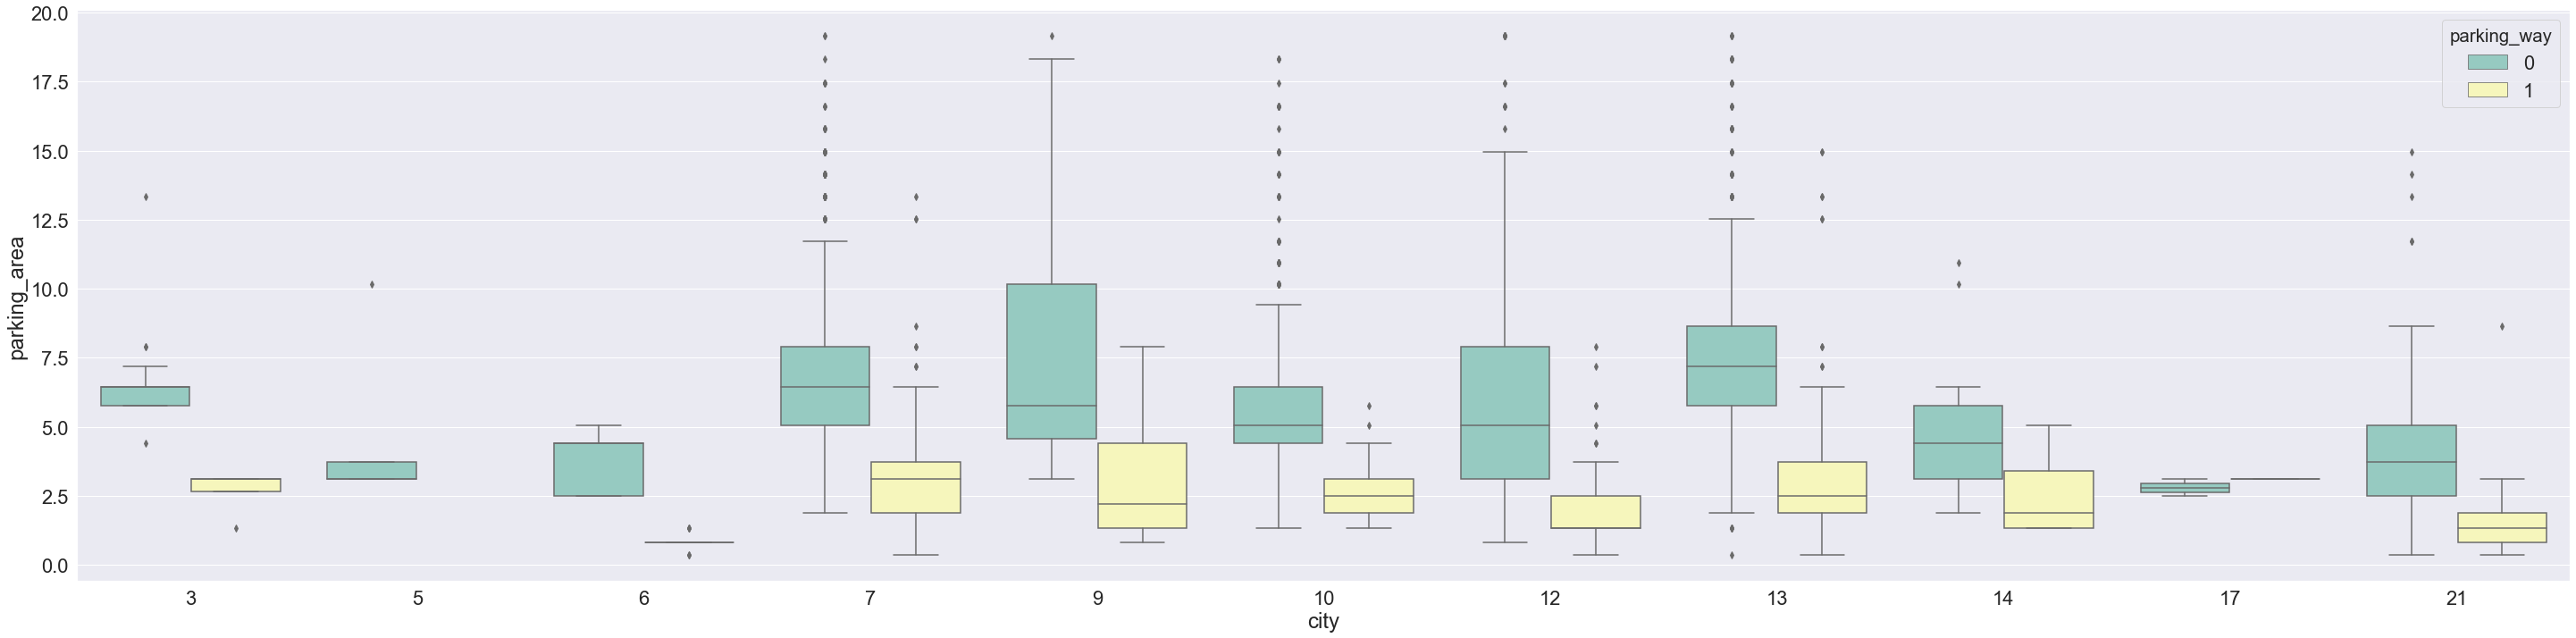

In [39]:
#查看各city不同parking_way的parking_area分布
#由於缺失值眾多且區間分布上無明顯規律，故建議放棄此欄位。
f = plt.figure(figsize=(50,40)) 
f.add_subplot(3, 1, 1) 
parkDf=parkDf[parkDf['parking_area']<=20]
sns.boxplot(x="city", y="parking_area",data=parkDf, palette="Set3",hue='parking_way')

In [40]:
df['CT']=df['city']*1000+df['town']
testDf['CT']=testDf['city']*1000+testDf['town']
#parking_price訓練資料集中，13,935筆只有18筆缺失值，即僅極少數為缺失值
#測試集資料中則僅有3筆為缺失值，故打算簡單以city平均數補值就好。
parkDf=df[(df['parking_way']==0) | (df['parking_way']==1)]
parkTestDf=testDf[(testDf['parking_way']==0) | (testDf['parking_way']==1)]
parkDfZero=parkDf[parkDf['parking_price']==0]
parkTestDfZero=parkTestDf[parkTestDf['parking_price']==0]
print(parkDf.shape)
print(parkDfZero.shape)
print(parkTestDf.shape)
print(parkTestDfZero.shape)

(13935, 250)
(18, 250)
(2290, 235)
(3, 235)


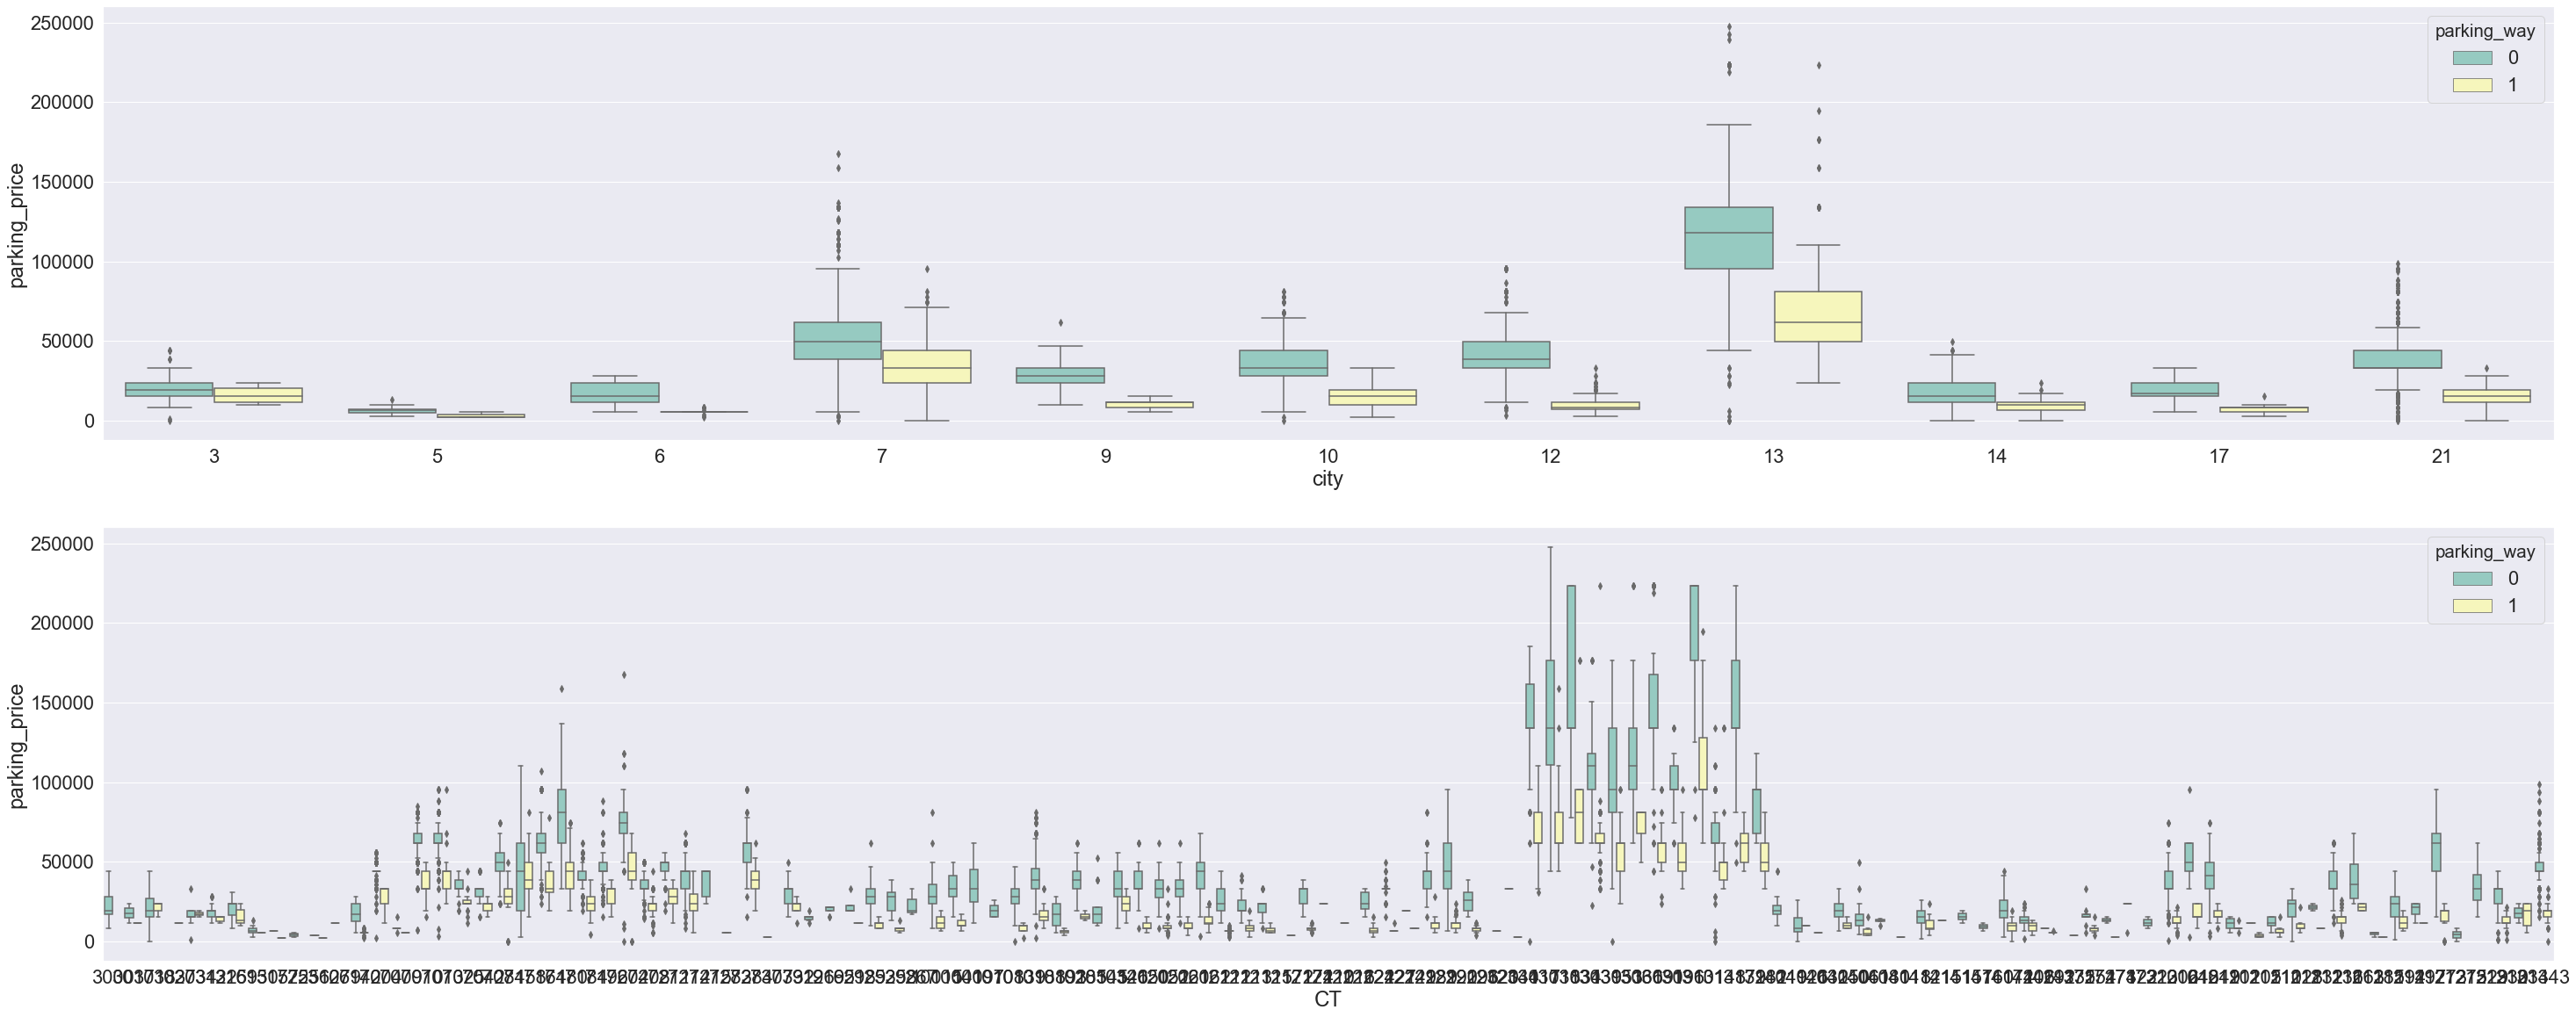

In [41]:
#查看各city不同parking_way的parking_price分布
f = plt.figure(figsize=(50,20)) 
parkDf=df[(df['parking_way']==0) | (df['parking_way']==1)]
parkDf=parkDf[parkDf['parking_price']<=250000]
f.add_subplot(2, 1, 1) 
sns.boxplot(x="city", y="parking_price",data=parkDf, palette="Set3",hue='parking_way')
f.add_subplot(2, 1, 2) 
sns.boxplot(x="CT", y="parking_price",data=parkDf, palette="Set3",hue='parking_way')

In [42]:
#利用隨機森林補缺失值,得到缺失值的預測答案，然後將答案寫回df (測試資料集比照辦理)
from  sklearn.ensemble import RandomForestClassifier
df=df.fillna(0)
te=df[((df['parking_way']==0) | (df['parking_way']==1)) & (df['parking_price']!=0)]
#補缺失值時考慮下述欄位
te_X=te[['city','town','parking_way','building_type','building_use','building_material']].astype(float)
te_Y=te['parking_price'].astype(float)
te_X=te_X.astype(float)
te_Y=te_Y.astype(int)
tr=df[((df['parking_way']==0) | (df['parking_way']==1)) & (df['parking_price']==0)]
tr_X=tr[['city','town','parking_way','building_type','building_use','building_material']].astype(float)
tr_Y=tr['parking_price'].astype(int)
fc=RandomForestClassifier()
fc.fit(te_X,te_Y)
pr=fc.predict(tr_X)
tr['parking_price']=pr
df.ix[((df.parking_way==0) | (df.parking_way==1)) & df.parking_price==0,'parking_price_new']=tr['total_price']
df['parking_price_new']=df['parking_price_new'].fillna(0)
df['parking_price']=df['parking_price']+df['parking_price_new']

In [43]:
#檢查是否還有缺失值
tr=df[((df['parking_way']==0) | (df['parking_way']==1)) & (df['parking_price']==0)]
tr.shape

(0, 251)

In [44]:
dfCopy = df.ix[len(df):]

In [45]:
dfCopy

Empty DataFrame
Columns: [building_id, building_material, city, txn_dt, total_floor, building_type, building_use, building_complete_dt, parking_way, parking_area, parking_price, txn_floor, land_area, building_area, town, lat, lon, town_population, town_area, town_population_density, doc_rate, master_rate, bachelor_rate, jobschool_rate, highschool_rate, junior_rate, elementary_rate, born_rate, death_rate, marriage_rate, divorce_rate, village, N_50, N_500, N_1000, N_5000, N_10000, I_10, I_50, I_index_50, I_100, I_250, I_500, I_index_500, I_1000, I_index_1000, I_5000, I_index_5000, I_10000, I_index_10000, I_MIN, II_10, II_50, II_index_50, II_100, II_250, II_500, II_index_500, II_1000, II_index_1000, II_5000, II_index_5000, II_10000, II_index_10000, II_MIN, III_10, III_50, III_index_50, III_100, III_250, III_500, III_index_500, III_1000, III_index_1000, III_5000, III_index_5000, III_10000, III_index_10000, III_MIN, IV_10, IV_50, IV_index_50, IV_100, IV_250, IV_500, IV_index_500, IV_1000, IV_index_1000, IV_5000, IV_index_5000, IV_10000, IV_index_10000, IV_MIN, V_10, V_50, V_index_50, V_100, V_250, V_500, V_index_500, ...]
Index: []

[0 rows x 251 columns]

In [46]:
#檢查離群值
#根據不同的Town與不同的building_type過濾每坪單價離群值
from scipy import stats
def getNonOulierDataByType(subDFType):
    global dfCopy
    z = np.abs(stats.zscore(subDFType.avg))
    threshold = 3
    non_outlier_indices = np.where(z < 3)[0]
    non_outlier_data = subDFType.iloc[non_outlier_indices]
    dfCopy=pd.concat( [dfCopy, non_outlier_data])


def getNonOulierData(df):
    CTList=df['CT'].unique().tolist()
    for CT in CTList:
        subDF=df[df['CT']==CT]
        typeList=df['building_type'].unique().tolist()
        for buildType in typeList:
            subDFType=subDF[subDF['building_type']==buildType]
            getNonOulierDataByType(subDFType)


#創建出一個空的dataframe，用來接收所有非離群值資料
dfCopy = df.ix[len(df):]
getNonOulierData(df)
dfCopy.index = range(len(dfCopy))


In [47]:
dfCopy.shape

(59192, 251)

In [48]:
#篩選後剩下59192筆資料
dfCopy.head()


building_id  building_material  city  txn_dt  total_floor  \
0  e3mMIMR3JJqCaXz1                  8    21   18674            4   
1  JoYEVOaiPCzxuCkN                  8    21   19243            9   
2  ZEqpX6fg3TfJF5Zy                  8    21   18330           10   
3  DkhvijNj0Mdw8WHh                  8    21   19783            8   
4  rcgnyPRknCLw9IAl                  8    21   18508           10   

   building_type  building_use  building_complete_dt  parking_way  \
0              3             2                  6271            2   
1              3             2                  6424            2   
2              3             2                 13272            2   
3              3             2                  7094            2   
4              3             2                 11872            2   

   parking_area  ...     CTDis  isOne  isTwo  isFour  isTop        dj   TU  \
0           0.0  ...  0.006429      0      0       0      0  5.308230  302   
1           0.0  ...  0.006429      0      0       0      0  1.384694  302   
2           0.0  ...  0.011888      0      0       0      0  1.300036  302   
3           0.0  ...  0.003571      0      0       0      0  1.602731  302   
4           0.0  ...  0.003571      0      0       0      0  1.006893  302   

         CTV  village_income_median_y  parking_price_new  
0  213343132               647.720324                0.0  
1  213341425               647.720324                0.0  
2  213342838               647.720324                0.0  
3  213342140               647.720324                0.0  
4  213342036               647.720324                0.0  

[5 rows x 251 columns]